In [1]:
import os
import pickle
from glob import glob

In [2]:
import numpy as np

import torch

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append("../src")

In [4]:
from utils.plots import input2image
from utils import plots

from my_model import get_ilsvrc2012
from utils.load_model import get_model

from utils.tensortracker import TensorTracker

from utils.performance_model import measure_performance

from utils.config import dict_from_config_file

In [5]:
n_classes = 1000

In [6]:
model_names = [
    ("resnet34-skip4", "resnet"),
    ("resnet34-skip", "resnet34-1"),
    ("resnet34-skip2", "resnet34-2"),
    ("resnet34-skip3", "resnet34-3"),
    ("resnet34-plain4", "plainnet"),
    ("resnet34-plain", "plainnet34-1"),
    ("resnet34-plain2", "plainnet34-2"),
    ("resnet34-plain3", "plainnet34-3"),
]

In [7]:
analysis_root = "/data2/genta/resnet/analysis/"
# rf_root = "/mnt/nas3/lab_member_directories/2021_genta/resnet/e_receptive_field/"
rf_root = "/mnt/nas5/lab_member_directories/2021_genta/resnet/e_receptive_field/"

In [8]:
def glob_analysis_root(analysis_root, model_name, key_layer, block_id):
    return glob(os.path.join(analysis_root, model_name + "*", key_layer + "*" + str(block_id)))

def glob_rf_root(rf_root, model_name, key_layer, block_id):
    return glob(os.path.join(rf_root, "*" + model_name + "*" + key_layer + "." + str(block_id) + "*"))

class RFdataLoader(object):
    def __init__(self, analysis_root, rf_root, keywords=None):
        self.analysis_root = analysis_root
        self.rf_root = rf_root
        if keywords is None or keywords == "all":
            self.keywords = {
                "rfimgs",
                "rfgrads",
                "channel",
                "config",
                "act_preact",
                "config-script"
            }
        elif isinstance(keywords, (set, list, tuple)):
            self.keywords = keywords
        else:
            raise TypeError("keywords" + type(keywords))
            
        self._fmap_shape = None
        self._dataset = None
        
            
    def set_vis_layer(self, model_name, key_layer, block_id):
        if "act_preact" in self.keywords:
            cond_path = glob_analysis_root(self.analysis_root, model_name, key_layer, block_id)
            assert len(cond_path) != 0, "Not found"
            assert len(cond_path) == 1, "ambiguous; model name or key_layer or block_id. you can check paths to use _show_glob_paths"
            self.act_dir_path = cond_path[0]
        else:
            self.act_dir_path = None

        cond_path = glob_rf_root(self.rf_root, model_name, key_layer, block_id)
        assert len(cond_path) != 0, "Not found"
        assert len(cond_path) == 1, "ambiguous; model name or key_layer or block_id. you can check paths to use _show_glob_paths"
        self.rf_dir_path = cond_path[0]

    def set_ch_data(self, ch):
        if self.rf_dir_path is None:
            msg = "do set_vis_layer"
            raise ValueError(msg)
        
        if "act_preact" in self.keywords:
            path = os.path.join(self.act_dir_path, "act_preact_{:03}.pkl".format(ch))
            with open(path, "rb") as f:
                self._act_preact = pickle.load(f)
        
        if "rfimgs" in self.keywords:
            path = os.path.join(self.rf_dir_path, "top_rf_datas", "rfimgs-{:03}.npy".format(ch))
            self._rfimgs = np.load(path)
        if "rfgrads" in self.keywords:
            path = os.path.join(self.rf_dir_path, "top_rf_datas", "rfgrads-{:03}.npy".format(ch))
            self._rfgrads = np.load(path)
            
        if "channel" in self.keywords:
            path = os.path.join(self.rf_dir_path, "top_activation", "channel-{:03}.pkl".format(ch))
            with open(path, "rb") as f:
                self._channel = pickle.load(f)
                
        if "config" in self.keywords:
            path = os.path.join(self.rf_dir_path, "config.pkl")
            with open(path, "rb") as f:
                self._config = pickle.load(f)

        if "config-script" in self.keywords:
            path = os.path.join(self.rf_dir_path, "config.yaml")
            self._config_script = dict_from_config_file(path)
        
    @property
    def dataset(self):
        if self._dataset is not None:
            return self._dataset
        self._dataset = get_ilsvrc2012(mode='test', val_txt=self._config_script["args"]["val_list"])
        return self._dataset
        
    @property
    def fmap_spatial_shape(self):
        h = self.config["layer_info"][0]
        w = h
        return (h, w)
        
    @property
    def activation_indeces(self):
        assert self.channel is not None
        if "fmap_shape" in self.config:
            return np.unravel_index(self.channel["top_act_index"], (self.config["len_dataset"], ) + self.config["fmap_shape"][-2:])
        else:
            len_dataset = len(self.dataset)
            return np.unravel_index(self.channel["top_act_index"], (len_dataset, ) + self.fmap_spatial_shape)
    
    @property
    def rfimgs(self):
        if "rfimgs" in self.keywords:
            return self._rfimgs
        else:
            return None
    
    @property
    def rfgrads(self):
        if "rfgrads" in self.keywords:
            return self._rfgrads
        else:
            return None

    @property
    def act_preact(self):
        if "_act_preact" in self.keywords:
            return self._act_preact
        else:
            return None

    @property
    def channel(self):
        if "channel" in self.keywords:
            return self._channel
        else:
            return None

    @property
    def config(self):
        if "config" in self.keywords:
            return self._config
        else:
            return None

    def _show_glob_paths(self, model_name, key_layer, block_id):
        print("analysis path")
        cond_path = glob_analysis_root(self.analysis_root, model_name, key_layer, block_id)
        print(cond_path)
        cond_path = glob_rf_root(self.rf_root, model_name, key_layer, block_id)
        print("rf path")
        print(cond_path)

In [9]:
keywords = {
    "channel",
    "config",
    "config-script"
}
rfdataloader = RFdataLoader(analysis_root, rf_root, keywords=keywords)

In [10]:
rfdataloader._show_glob_paths("resnet34-skip_", "layer4", 2)

analysis path
[]
rf path
['/mnt/nas5/lab_member_directories/2021_genta/resnet/e_receptive_field/resnet34-skip_layer-layer4.2.relu2_act-layer4.2.relu2']


In [11]:
resnet34_model_names = [
    "20200409_resnet34",
    "resnet34-skip_",
    "resnet34-skip2_",
    "resnet34-skip3_",
]

plainnet34_model_names = [
    "20200409_plainnet34",
    "resnet34-plain_",
    "resnet34-plain2_",
    "resnet34-plain3_",
]

In [12]:
data_resnets = {}
data_plainnets = {}

In [13]:
%%time 
key_layer = "layer4"
block_id = 2
for model_name in resnet34_model_names:
    rfdataloader.set_vis_layer(model_name, key_layer, block_id)
    def get_top_act_classes(model_name, key_layer, block_id):
        rfdataloader.set_vis_layer(model_name, key_layer, block_id)
        top_act_classes = []
        ch_max = 512
        for ch in range(ch_max):
            rfdataloader.set_ch_data(ch)
            img_idxs = rfdataloader.activation_indeces[0][:100]
            top_act_classes.append(np.array(rfdataloader.dataset.targets)[img_idxs])
        top_act_classes = np.asarray(top_act_classes)
        return top_act_classes.copy()

    res_top_act_classes = get_top_act_classes(model_name, key_layer, block_id)
    res_uniques = [np.unique(x, return_counts=True) for x in res_top_act_classes]
    res_unique_len = np.asarray([len(unique) for unique, _ in res_uniques])
    
    key = "{}-{}-{}".format(model_name, key_layer, block_id)
    data_resnets[key] = [
        res_top_act_classes,
        res_uniques,
        res_unique_len
    ]

for model_name in plainnet34_model_names:
    rfdataloader.set_vis_layer(model_name, key_layer, block_id)
    def get_top_act_classes(model_name, key_layer, block_id):
        rfdataloader.set_vis_layer(model_name, key_layer, block_id)
        top_act_classes = []
        ch_max = 512
        for ch in range(ch_max):
            rfdataloader.set_ch_data(ch)
            img_idxs = rfdataloader.activation_indeces[0][:100]
            top_act_classes.append(np.array(rfdataloader.dataset.targets)[img_idxs])
        top_act_classes = np.asarray(top_act_classes)
        return top_act_classes.copy()

    res_top_act_classes = get_top_act_classes(model_name, key_layer, block_id)
    res_uniques = [np.unique(x, return_counts=True) for x in res_top_act_classes]
    res_unique_len = np.asarray([len(unique) for unique, _ in res_uniques])
    
    key = "{}-{}-{}".format(model_name, key_layer, block_id)
    data_plainnets[key] = [
        res_top_act_classes,
        res_uniques,
        res_unique_len
    ]

CPU times: user 31.2 s, sys: 3.05 s, total: 34.2 s
Wall time: 1min 4s


In [14]:
data_resnets.keys()

dict_keys(['20200409_resnet34-layer4-2', 'resnet34-skip_-layer4-2', 'resnet34-skip2_-layer4-2', 'resnet34-skip3_-layer4-2'])

In [15]:
res_unique_lens = []
for key, item in  data_resnets.items():
    if "{}-{}".format(key_layer, block_id) in key:
        res_unique_lens.append(item[2])
res_unique_lens = np.asarray(res_unique_lens)

plain_unique_lens = []
for key, item in  data_plainnets.items():
    if "{}-{}".format(key_layer, block_id) in key:
        plain_unique_lens.append(item[2])
plain_unique_lens = np.asarray(plain_unique_lens)

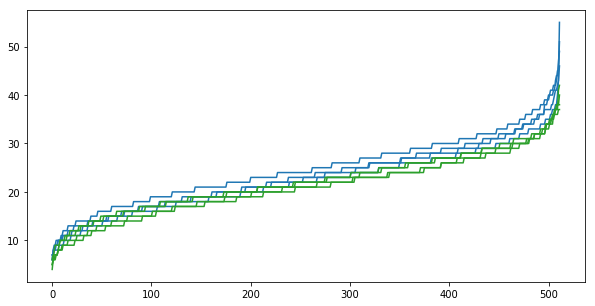

In [16]:
plt.figure(figsize=(10, 5))
for data in np.sort(res_unique_lens, axis=-1):
    plt.plot(data, color="tab:blue")
for data in np.sort(plain_unique_lens, axis=-1):
    plt.plot(data, color="tab:green")

plt.show()

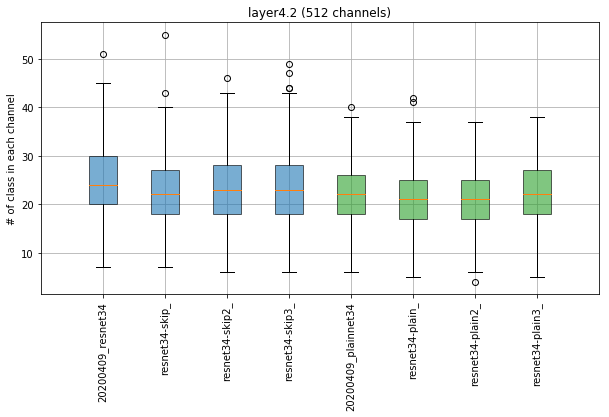

In [17]:


data_res_size = len(res_unique_lens)
data_plain_size = len(plain_unique_lens)
alpha = 0.6
channel_size = 512
plt.figure(figsize=(10, 5))
boxprops = {
    "facecolor": "tab:blue",
    "alpha": alpha,
}
plt.boxplot(res_unique_lens.T, positions=np.arange(data_res_size), patch_artist=True, boxprops=boxprops)
boxprops = {
    "facecolor": "tab:green",
    "alpha": alpha,
}
plt.boxplot(plain_unique_lens.T, positions=np.arange(data_res_size, data_plain_size + data_res_size), patch_artist=True, boxprops=boxprops)
plt.xlim(0 - 1, data_res_size + data_plain_size)
plt.xticks(ticks=np.arange(data_res_size + data_plain_size), labels=resnet34_model_names + plainnet34_model_names, rotation=90)
msg = "{}.{} ({} channels)".format(key_layer, block_id, channel_size)
plt.title(msg)
msg = "# of class in each channel"
plt.ylabel(msg)
# plt.xlabel(msg)
plt.grid()
plt.show()

In [18]:
%%time
key_layer = "layer4"
block_id = 1
for model_name in resnet34_model_names:
    rfdataloader.set_vis_layer(model_name, key_layer, block_id)
    def get_top_act_classes(model_name, key_layer, block_id):
        rfdataloader.set_vis_layer(model_name, key_layer, block_id)
        top_act_classes = []
        ch_max = 512
        for ch in range(ch_max):
            rfdataloader.set_ch_data(ch)
            img_idxs = rfdataloader.activation_indeces[0][:100]
            top_act_classes.append(np.array(rfdataloader.dataset.targets)[img_idxs])
        top_act_classes = np.asarray(top_act_classes)
        return top_act_classes.copy()

    res_top_act_classes = get_top_act_classes(model_name, key_layer, block_id)
    res_uniques = [np.unique(x, return_counts=True) for x in res_top_act_classes]
    res_unique_len = np.asarray([len(unique) for unique, _ in res_uniques])
    
    key = "{}-{}-{}".format(model_name, key_layer, block_id)
    data_resnets[key] = [
        res_top_act_classes,
        res_uniques,
        res_unique_len
    ]

for model_name in plainnet34_model_names:
    rfdataloader.set_vis_layer(model_name, key_layer, block_id)
    def get_top_act_classes(model_name, key_layer, block_id):
        rfdataloader.set_vis_layer(model_name, key_layer, block_id)
        top_act_classes = []
        ch_max = 512
        for ch in range(ch_max):
            rfdataloader.set_ch_data(ch)
            img_idxs = rfdataloader.activation_indeces[0][:100]
            top_act_classes.append(np.array(rfdataloader.dataset.targets)[img_idxs])
        top_act_classes = np.asarray(top_act_classes)
        return top_act_classes.copy()

    res_top_act_classes = get_top_act_classes(model_name, key_layer, block_id)
    res_uniques = [np.unique(x, return_counts=True) for x in res_top_act_classes]
    res_unique_len = np.asarray([len(unique) for unique, _ in res_uniques])
    
    key = "{}-{}-{}".format(model_name, key_layer, block_id)
    data_plainnets[key] = [
        res_top_act_classes,
        res_uniques,
        res_unique_len
    ]

CPU times: user 31.2 s, sys: 3.27 s, total: 34.5 s
Wall time: 1min 4s


In [19]:
res_unique_lens = []
for _, item in  data_resnets.items():
    res_unique_lens.append(item[2])
res_unique_lens = np.asarray(res_unique_lens)

plain_unique_lens = []
for _, item in  data_plainnets.items():
    plain_unique_lens.append(item[2])
plain_unique_lens = np.asarray(plain_unique_lens)

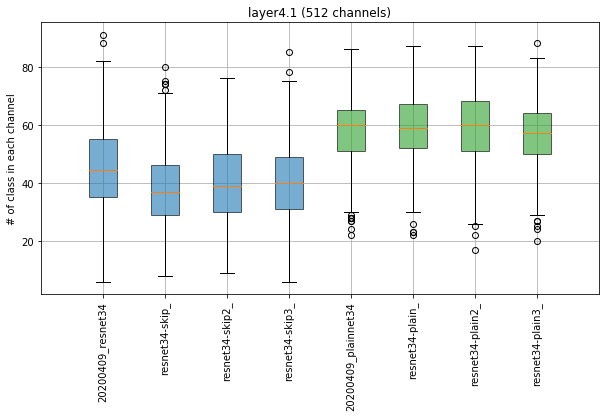

In [20]:
res_unique_lens = []
for key, item in  data_resnets.items():
    if "{}-{}".format(key_layer, block_id) in key:
        res_unique_lens.append(item[2])
res_unique_lens = np.asarray(res_unique_lens)

plain_unique_lens = []
for key, item in  data_plainnets.items():
    if "{}-{}".format(key_layer, block_id) in key:
        plain_unique_lens.append(item[2])
plain_unique_lens = np.asarray(plain_unique_lens)

data_res_size = len(res_unique_lens)
data_plain_size = len(plain_unique_lens)
alpha = 0.6
channel_size = 512
plt.figure(figsize=(10, 5))
boxprops = {
    "facecolor": "tab:blue",
    "alpha": alpha,
}
plt.boxplot(res_unique_lens.T, positions=np.arange(data_res_size), patch_artist=True, boxprops=boxprops)
boxprops = {
    "facecolor": "tab:green",
    "alpha": alpha,
}
plt.boxplot(plain_unique_lens.T, positions=np.arange(data_res_size, data_plain_size + data_res_size), patch_artist=True, boxprops=boxprops)
plt.xlim(0 - 1, data_res_size + data_plain_size)
plt.xticks(ticks=np.arange(data_res_size + data_plain_size), labels=resnet34_model_names + plainnet34_model_names, rotation=90)
msg = "{}.{} ({} channels)".format(key_layer, block_id, channel_size)
plt.title(msg)
msg = "# of class in each channel"
plt.ylabel(msg)
# plt.xlabel(msg)
plt.grid()
plt.show()

In [21]:
%%time
key_layer = "layer4"
block_id = 0
for model_name in resnet34_model_names:
    rfdataloader.set_vis_layer(model_name, key_layer, block_id)
    def get_top_act_classes(model_name, key_layer, block_id):
        rfdataloader.set_vis_layer(model_name, key_layer, block_id)
        top_act_classes = []
        ch_max = 512
        for ch in range(ch_max):
            rfdataloader.set_ch_data(ch)
            img_idxs = rfdataloader.activation_indeces[0][:100]
            top_act_classes.append(np.array(rfdataloader.dataset.targets)[img_idxs])
        top_act_classes = np.asarray(top_act_classes)
        return top_act_classes.copy()

    res_top_act_classes = get_top_act_classes(model_name, key_layer, block_id)
    res_uniques = [np.unique(x, return_counts=True) for x in res_top_act_classes]
    res_unique_len = np.asarray([len(unique) for unique, _ in res_uniques])
    
    key = "{}-{}-{}".format(model_name, key_layer, block_id)
    data_resnets[key] = [
        res_top_act_classes,
        res_uniques,
        res_unique_len
    ]

for model_name in plainnet34_model_names:
    rfdataloader.set_vis_layer(model_name, key_layer, block_id)
    def get_top_act_classes(model_name, key_layer, block_id):
        rfdataloader.set_vis_layer(model_name, key_layer, block_id)
        top_act_classes = []
        ch_max = 512
        for ch in range(ch_max):
            rfdataloader.set_ch_data(ch)
            img_idxs = rfdataloader.activation_indeces[0][:100]
            top_act_classes.append(np.array(rfdataloader.dataset.targets)[img_idxs])
        top_act_classes = np.asarray(top_act_classes)
        return top_act_classes.copy()

    res_top_act_classes = get_top_act_classes(model_name, key_layer, block_id)
    res_uniques = [np.unique(x, return_counts=True) for x in res_top_act_classes]
    res_unique_len = np.asarray([len(unique) for unique, _ in res_uniques])
    
    key = "{}-{}-{}".format(model_name, key_layer, block_id)
    data_plainnets[key] = [
        res_top_act_classes,
        res_uniques,
        res_unique_len
    ]

CPU times: user 31 s, sys: 3.16 s, total: 34.1 s
Wall time: 1min 4s


In [22]:
key

'resnet34-plain3_-layer4-0'

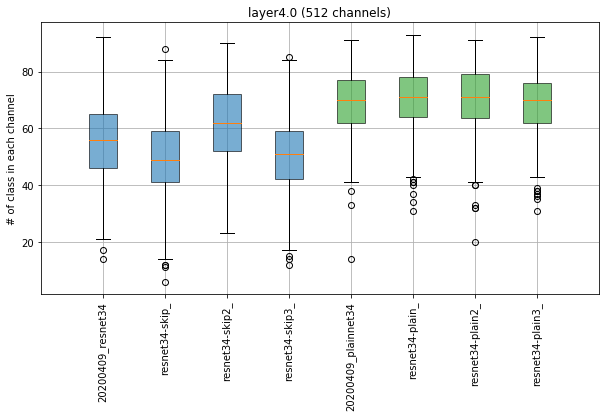

In [23]:
res_unique_lens = []
for key, item in  data_resnets.items():
    if "{}-{}".format(key_layer, block_id) in key:
        res_unique_lens.append(item[2])
res_unique_lens = np.asarray(res_unique_lens)

plain_unique_lens = []
for key, item in  data_plainnets.items():
    if "{}-{}".format(key_layer, block_id) in key:
        plain_unique_lens.append(item[2])
plain_unique_lens = np.asarray(plain_unique_lens)

data_res_size = len(res_unique_lens)
data_plain_size = len(plain_unique_lens)
alpha = 0.6
channel_size = 512
plt.figure(figsize=(10, 5))
boxprops = {
    "facecolor": "tab:blue",
    "alpha": alpha,
}
plt.boxplot(res_unique_lens.T, positions=np.arange(data_res_size), patch_artist=True, boxprops=boxprops)
boxprops = {
    "facecolor": "tab:green",
    "alpha": alpha,
}
plt.boxplot(plain_unique_lens.T, positions=np.arange(data_res_size, data_plain_size + data_res_size), patch_artist=True, boxprops=boxprops)
plt.xlim(0 - 1, data_res_size + data_plain_size)
plt.xticks(ticks=np.arange(data_res_size + data_plain_size), labels=resnet34_model_names + plainnet34_model_names, rotation=90)
msg = "{}.{} ({} channels)".format(key_layer, block_id, channel_size)
plt.title(msg)
msg = "# of class in each channel"
plt.ylabel(msg)
# plt.xlabel(msg)
plt.grid()
plt.show()

In [24]:
vmin = n_classes + 1
vmax = -1
for _, item in data_resnets.items():
    _vmin = item[2].min()
    _vmax = item[2].max()
    if _vmin < vmin:
        vmin = _vmin
    if _vmax > vmax:
        vmax = _vmax
for _, item in data_plainnets.items():
    _vmin = item[2].min()
    _vmax = item[2].max()
    if _vmin < vmin:
        vmin = _vmin
    if _vmax > vmax:
        vmax = _vmax


In [25]:
vmin, vmax

(4, 93)

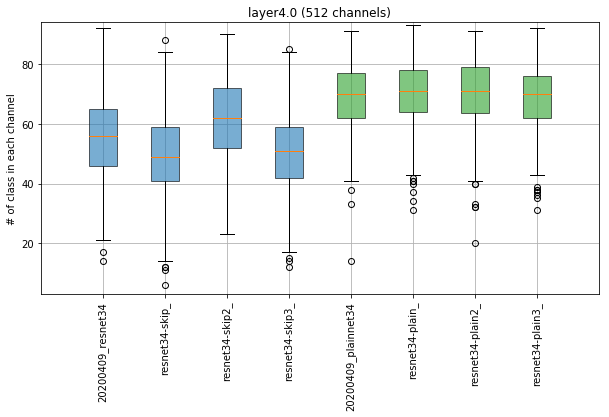

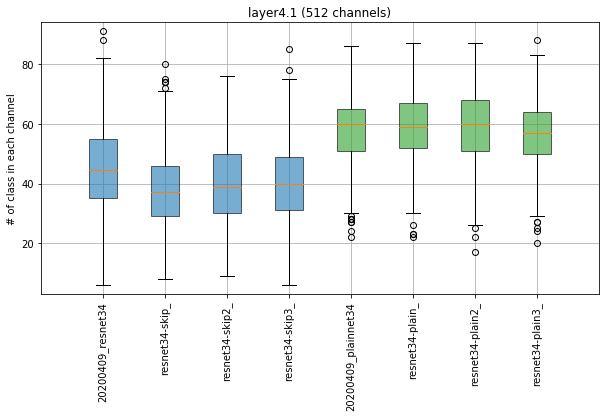

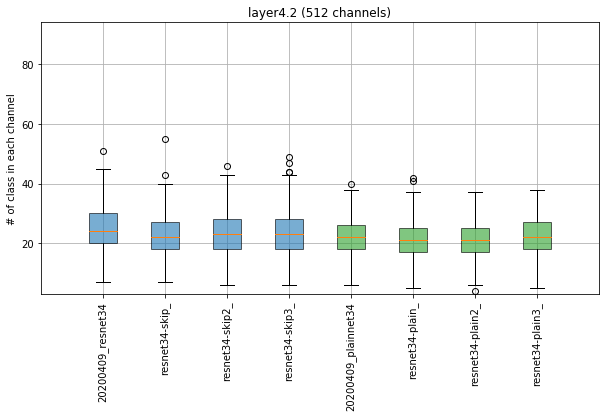

In [26]:
for block_id in (0, 1, 2):
    res_unique_lens = []
    for key, item in  data_resnets.items():
        if "{}-{}".format(key_layer, block_id) in key:
            res_unique_lens.append(item[2])
    res_unique_lens = np.asarray(res_unique_lens)

    plain_unique_lens = []
    for key, item in  data_plainnets.items():
        if "{}-{}".format(key_layer, block_id) in key:
            plain_unique_lens.append(item[2])
    plain_unique_lens = np.asarray(plain_unique_lens)

    data_res_size = len(res_unique_lens)
    data_plain_size = len(plain_unique_lens)
    alpha = 0.6
    channel_size = 512
    plt.figure(figsize=(10, 5))
    boxprops = {
        "facecolor": "tab:blue",
        "alpha": alpha,
    }
    plt.boxplot(res_unique_lens.T, positions=np.arange(data_res_size), patch_artist=True, boxprops=boxprops)
    boxprops = {
        "facecolor": "tab:green",
        "alpha": alpha,
    }
    plt.boxplot(plain_unique_lens.T, positions=np.arange(data_res_size, data_plain_size + data_res_size), patch_artist=True, boxprops=boxprops)
    plt.xlim(0 - 1, data_res_size + data_plain_size)
    plt.xticks(ticks=np.arange(data_res_size + data_plain_size), labels=resnet34_model_names + plainnet34_model_names, rotation=90)
    msg = "{}.{} ({} channels)".format(key_layer, block_id, channel_size)
    plt.title(msg)
    msg = "# of class in each channel"
    plt.ylabel(msg)
    plt.ylim(vmin - 1, vmax + 1)
    plt.grid()
    plt.show()

In [27]:
resnet34_model_names

['20200409_resnet34', 'resnet34-skip_', 'resnet34-skip2_', 'resnet34-skip3_']

In [28]:
resnet34_model_keys = [
    "resnet34-skip4",
    "resnet34-skip",
    "resnet34-skip2",
    "resnet34-skip3",
]

plainnet34_model_keys = [
    "resnet34-plain4",
    "resnet34-plain",
    "resnet34-plain2",
    "resnet34-plain3",
]

In [29]:
resnet34_weights = []
for name in resnet34_model_keys:
    model = get_model(name)
    resnet34_weights.append(model.fc.weight.to("cpu").detach().numpy())
resnet34_weights = np.asarray(resnet34_weights)

In [30]:
plainnet34_weights = []
for name in plainnet34_model_keys:
    model = get_model(name)
    plainnet34_weights.append(model.fc.weight.to("cpu").detach().numpy())
plainnet34_weights = np.asarray(plainnet34_weights)

In [31]:
resnet34_weights.shape, plainnet34_weights.shape

((4, 1000, 512), (4, 1000, 512))

In [32]:
key_layer = "layer4"
block_id = 2
res_unique_lens = []
for key, item in  data_resnets.items():
    if "{}-{}".format(key_layer, block_id) in key:
        res_unique_lens.append(item[2])
res_unique_lens = np.asarray(res_unique_lens)

plain_unique_lens = []
for key, item in  data_plainnets.items():
    if "{}-{}".format(key_layer, block_id) in key:
        plain_unique_lens.append(item[2])
plain_unique_lens = np.asarray(plain_unique_lens)

In [33]:
res_unique_lens.shape

(4, 512)

In [34]:
resnet34_model_names[0]

'20200409_resnet34'

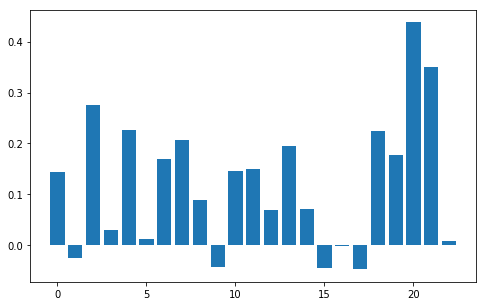

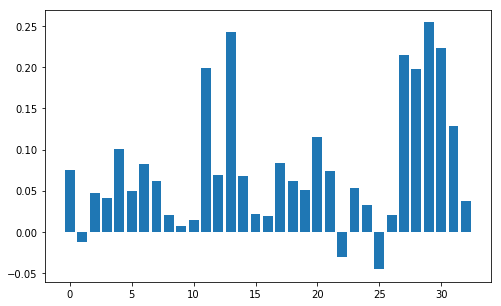

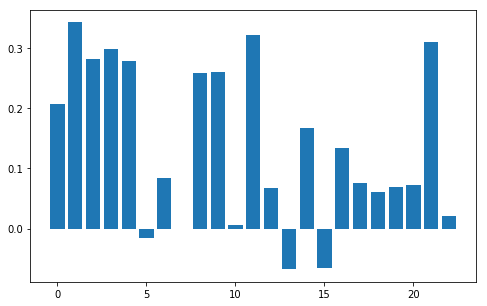

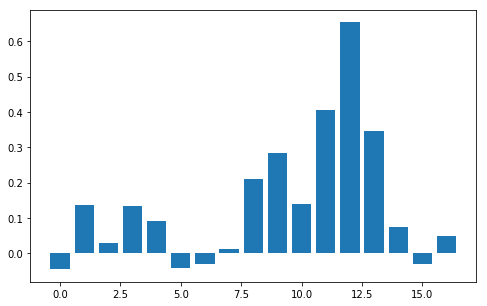

In [35]:
ch = 0
for i in range(4):
    key = "{}-{}-{}".format(resnet34_model_names[i], key_layer, block_id)
    data = resnet34_weights[i][data_resnets[key][1][ch][0], ch]
    plt.figure(figsize=(8, 5))
    plt.bar(np.arange(len(data)), data)
    plt.show()

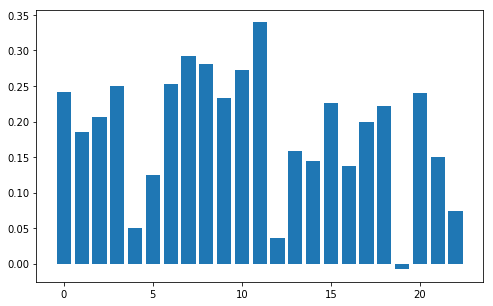

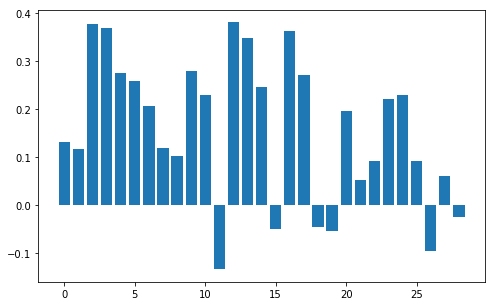

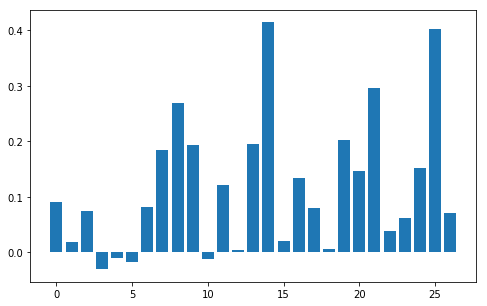

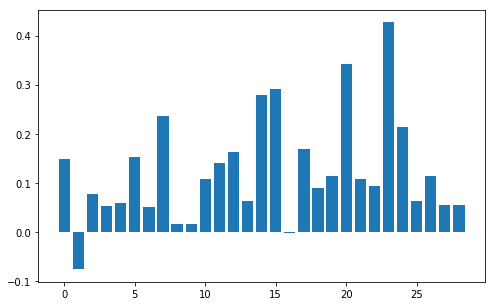

In [36]:
ch = 0
for i in range(4):
    key = "{}-{}-{}".format(plainnet34_model_names[i], key_layer, block_id)
    data = plainnet34_weights[i][data_plainnets[key][1][ch][0], ch]
    plt.figure(figsize=(8, 5))
    plt.bar(np.arange(len(data)), data)
    plt.show()

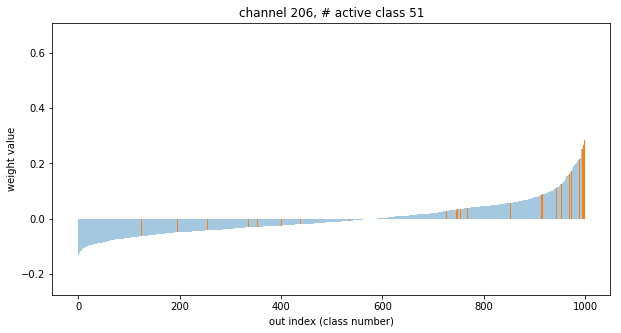

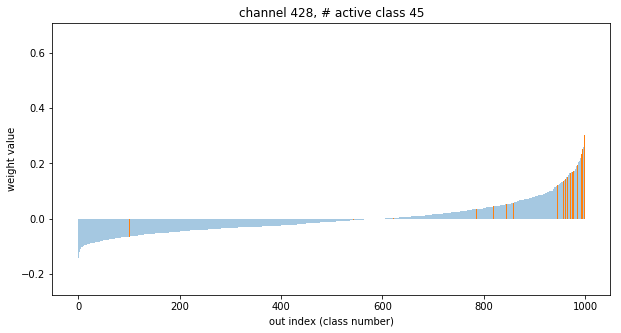

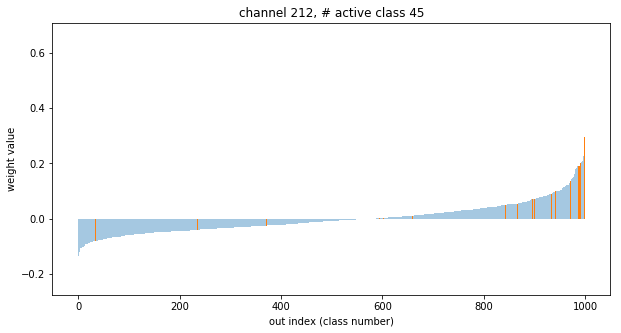

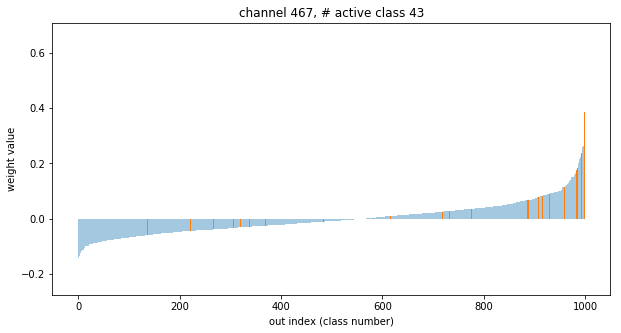

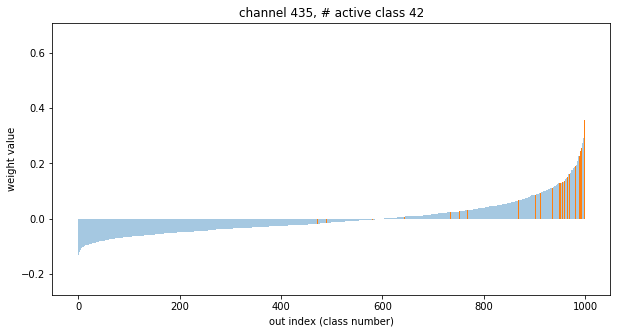

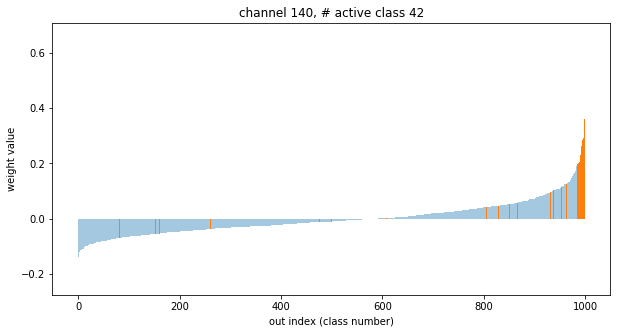

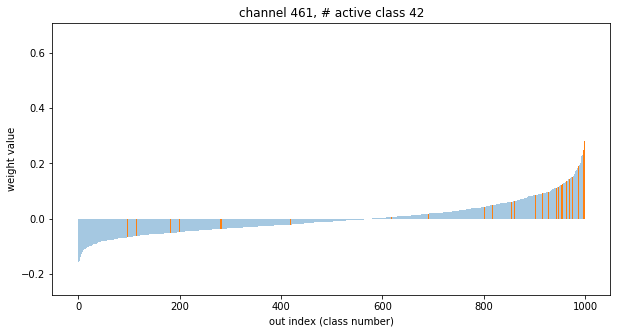

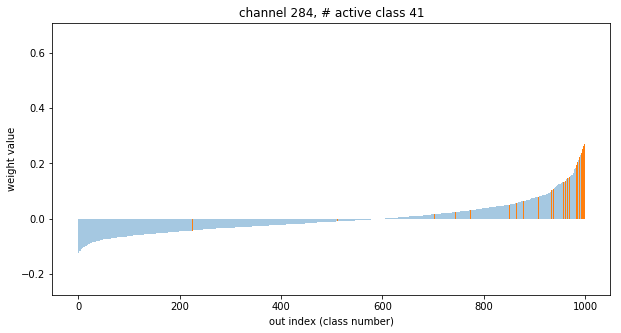

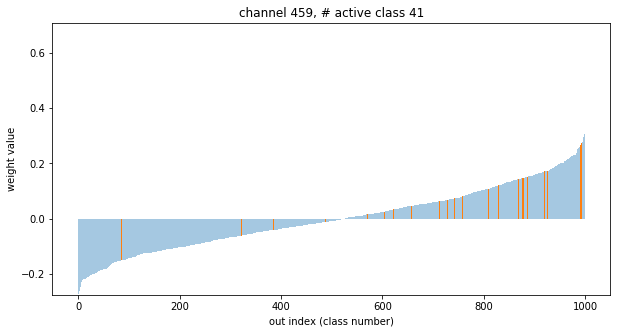

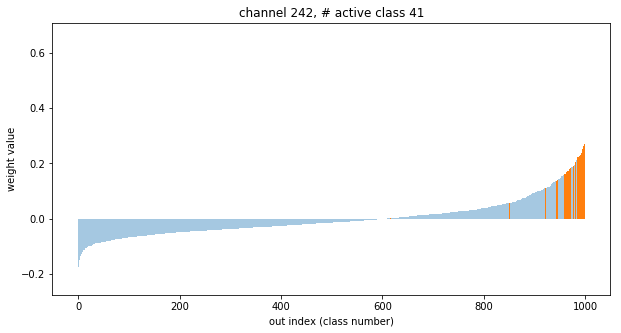

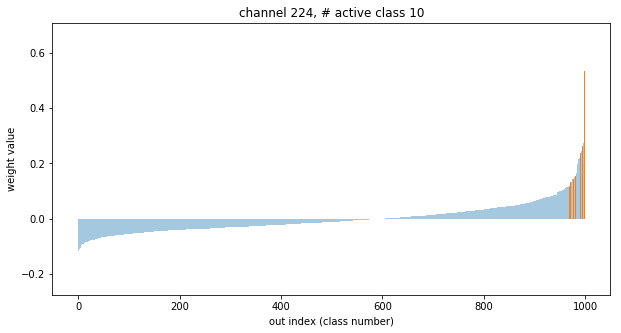

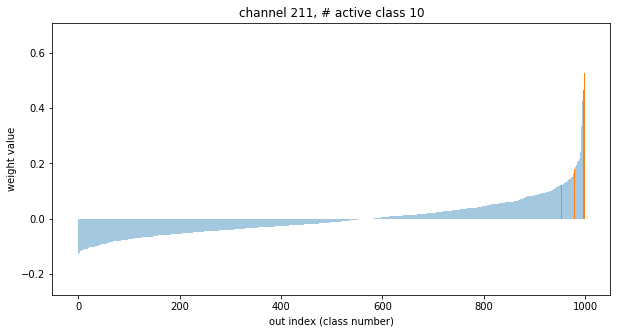

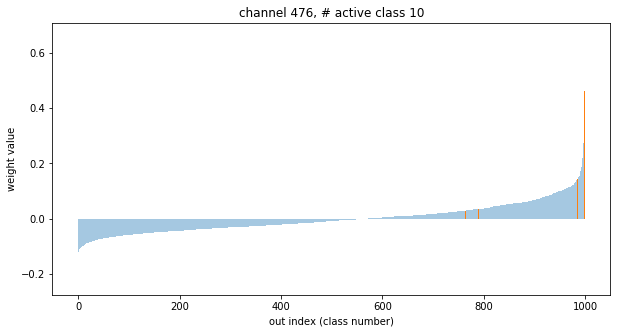

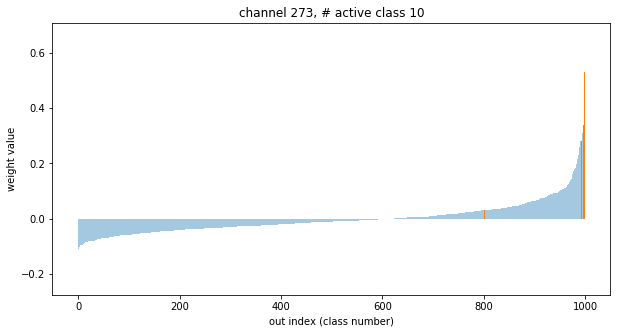

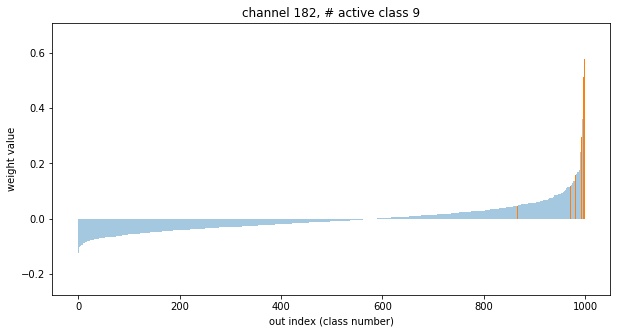

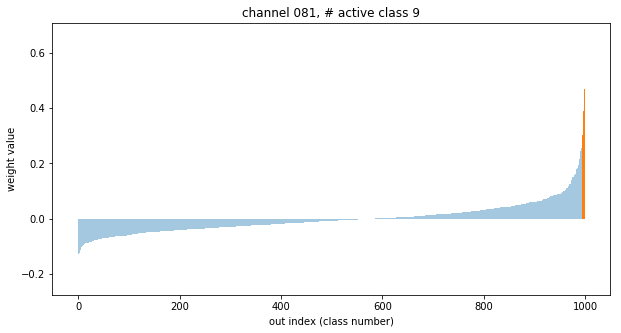

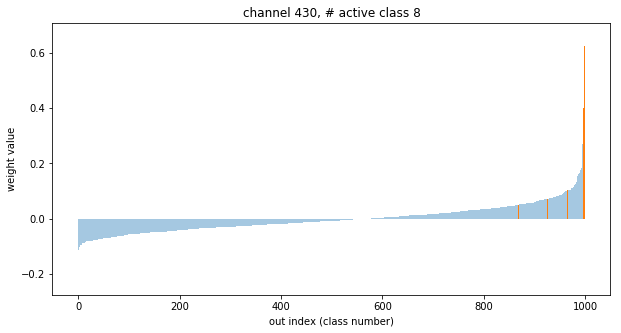

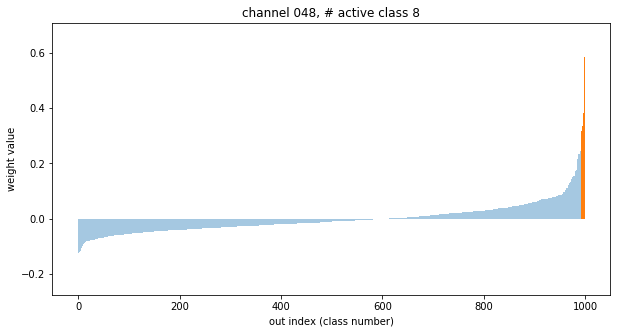

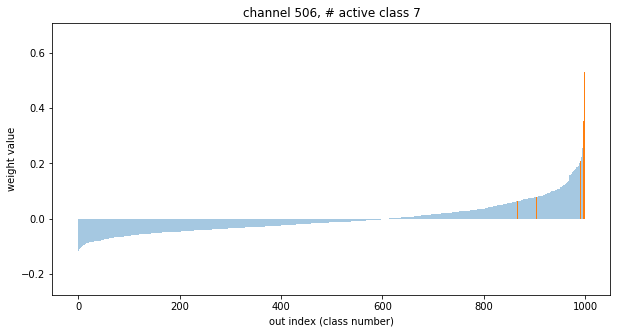

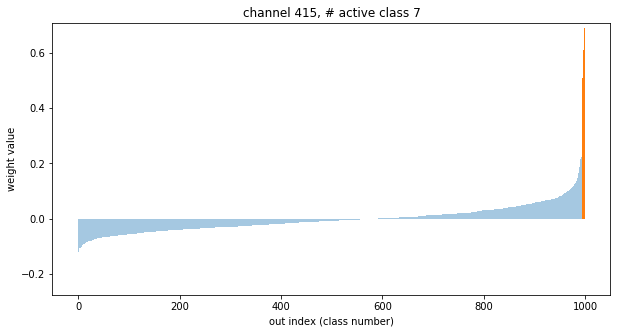

In [38]:
i = 0
n_samples = 10
sort_target = res_unique_lens[i]
vmin = resnet34_weights[i].min()
vmax = resnet34_weights[i].max()
sorted_channels = np.argsort(sort_target)[::-1]
for ch in np.concatenate((sorted_channels[:n_samples], sorted_channels[-n_samples:])):
    
    key = "{}-{}-{}".format(resnet34_model_names[i], key_layer, block_id)
    data0 = data_resnets[key][1][ch][0]
    data = resnet34_weights[i][:, ch]
    plt.figure(figsize=(10, 5))
    msg = "channel {:03}, # active class {}".format(ch, sort_target[ch])
    plt.title(msg)
    plt.bar(np.arange(len(data)), np.sort(data), width=1.0, alpha=0.4)
    tmp_index = np.isin(np.argsort(data), data0)
    plt.bar(np.arange(len(data))[tmp_index], np.sort(data)[tmp_index], width=1.0, color="tab:orange")
    plt.xlabel("out index (class number)")
    plt.ylabel("weight value")
    plt.ylim(vmin, vmax)
    plt.show()

In [39]:
i = 0
sort_target = res_unique_lens[i]
sorted_channels = np.argsort(sort_target)[::-1]

In [40]:
sorted_channels[:n_samples]

array([206, 428, 212, 467, 435, 140, 461, 284, 459, 242])

In [41]:
i = 0
sort_target = plain_unique_lens[i]
sorted_channels = np.argsort(sort_target)[::-1]

In [42]:
sorted_channels[:n_samples]

array([466,  37,  89, 104, 441, 421, 159, 455, 402, 295])

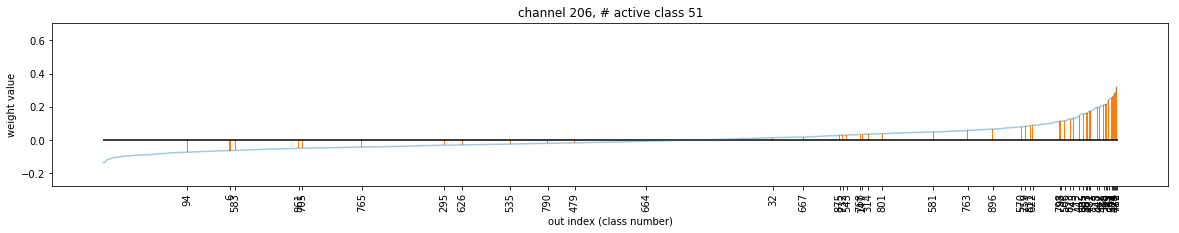

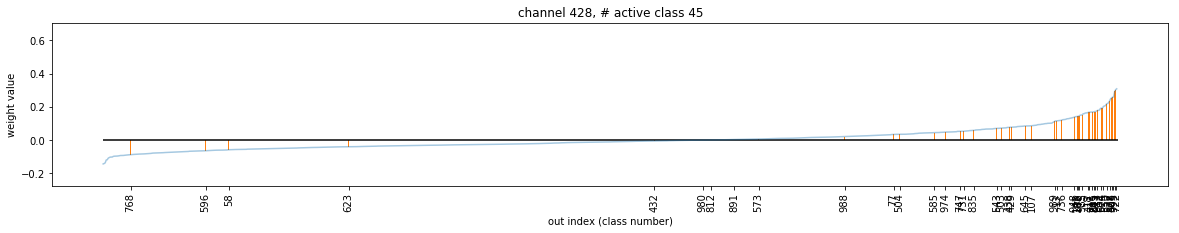

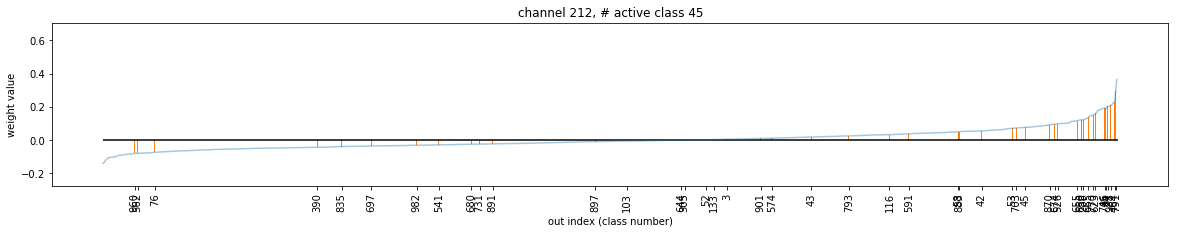

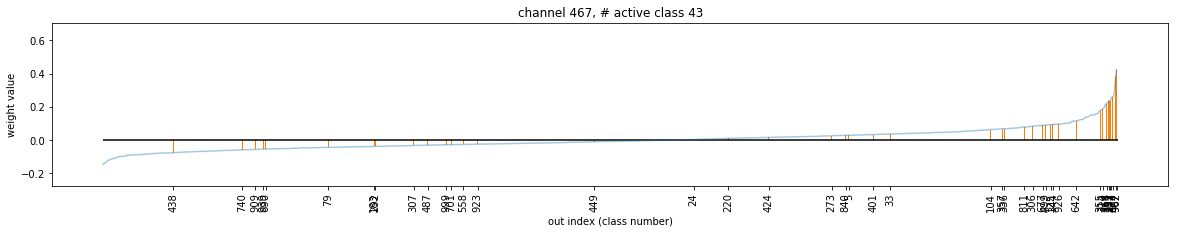

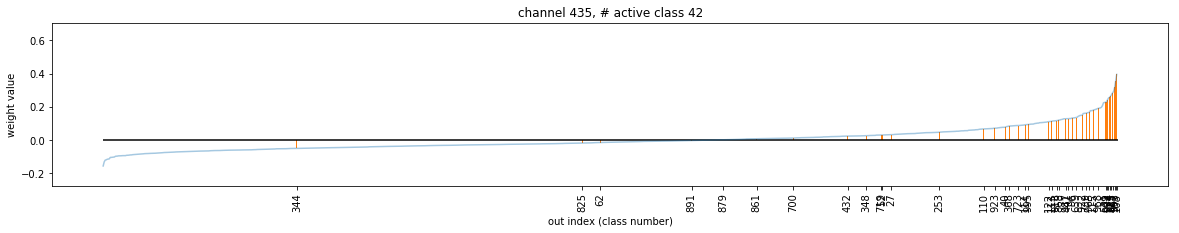

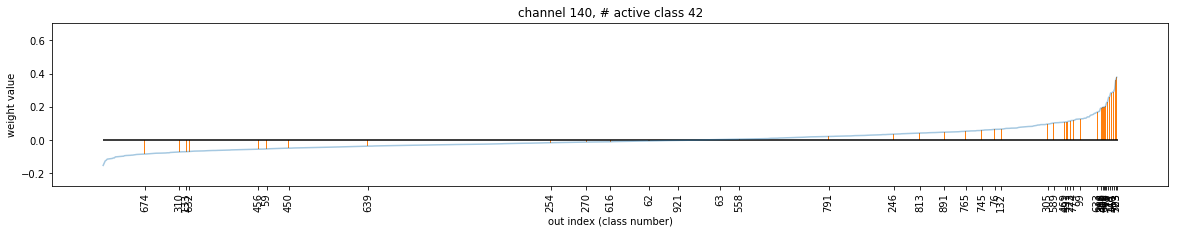

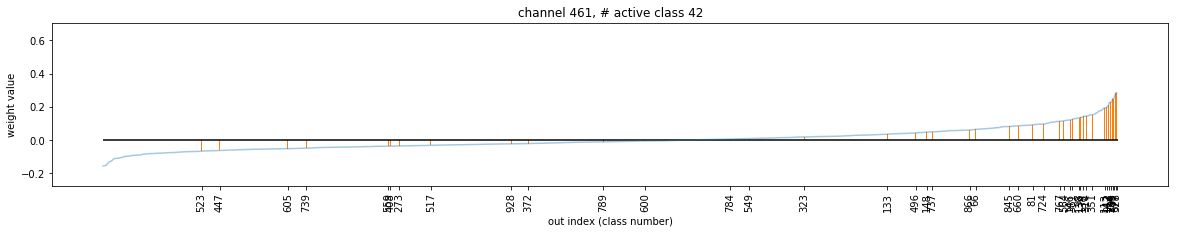

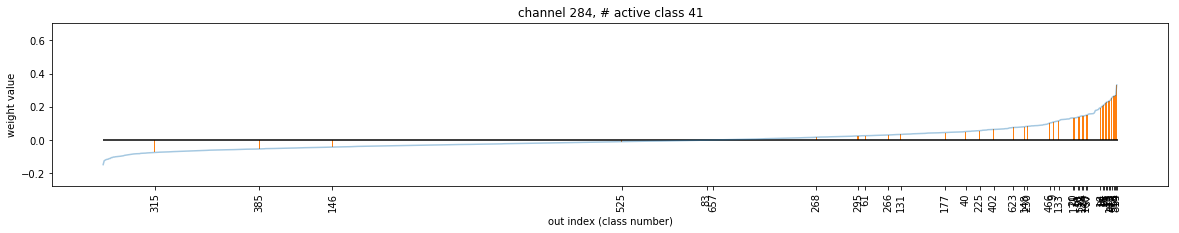

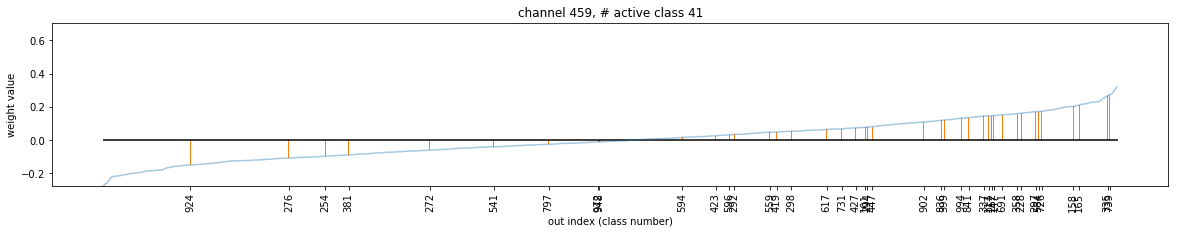

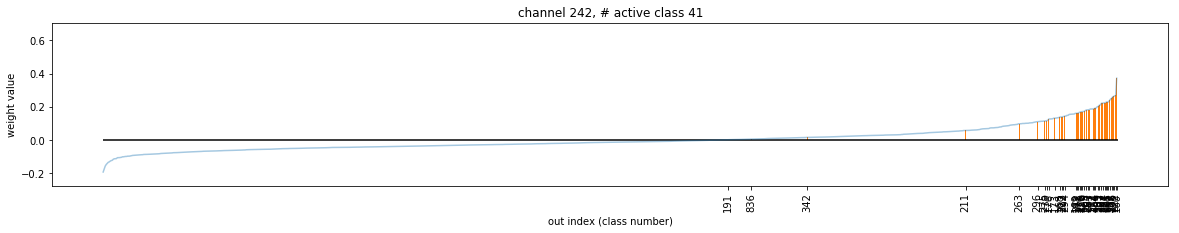

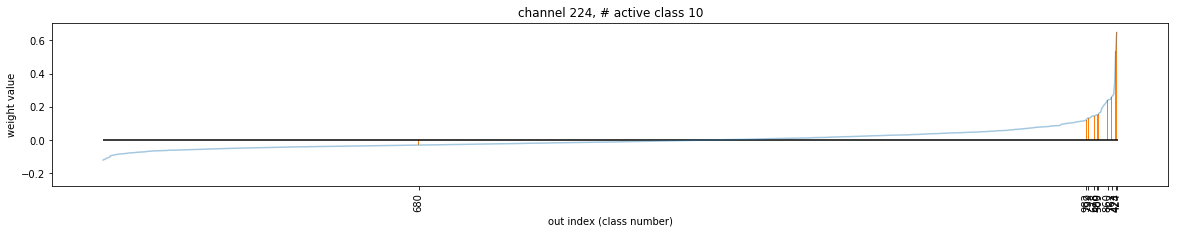

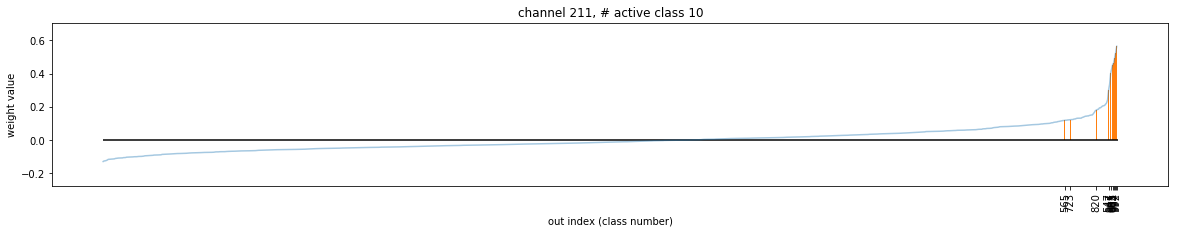

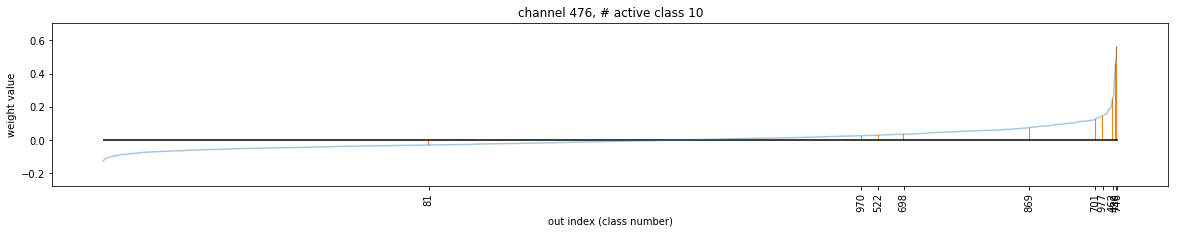

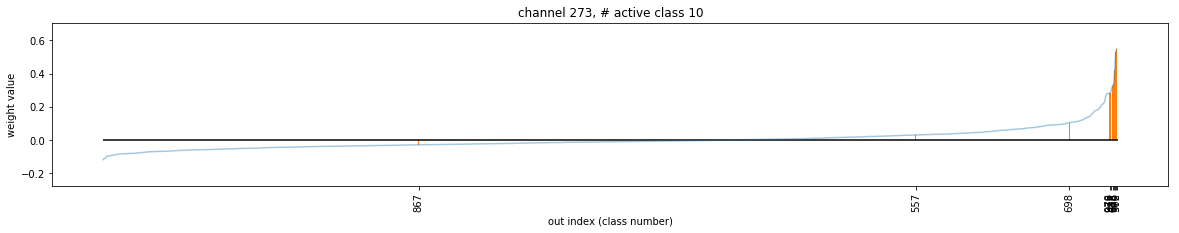

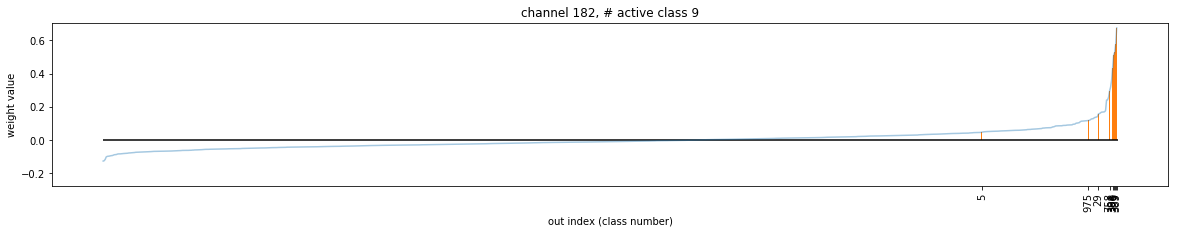

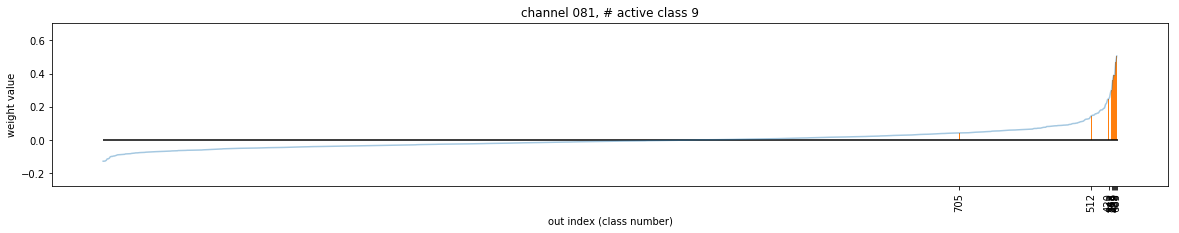

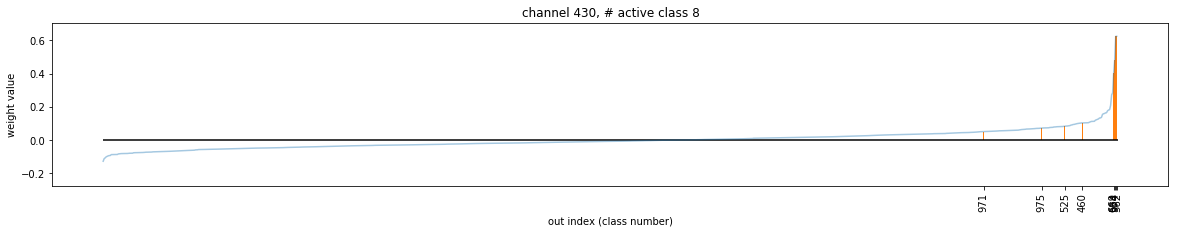

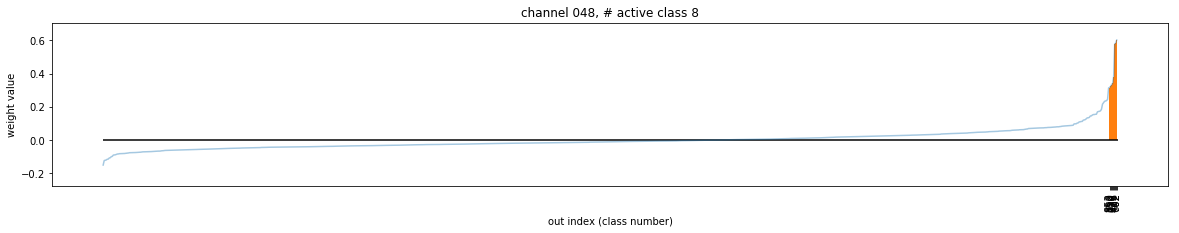

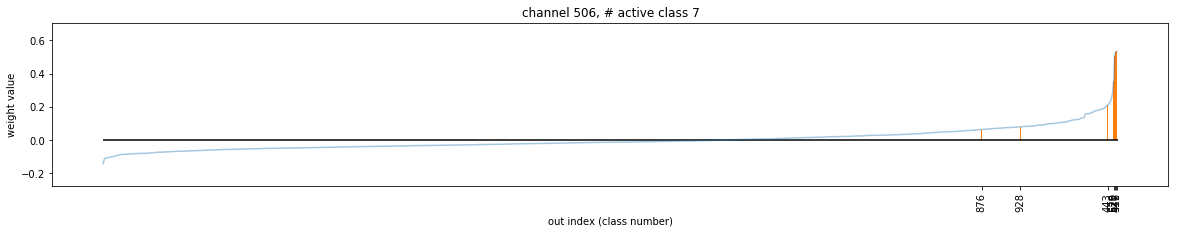

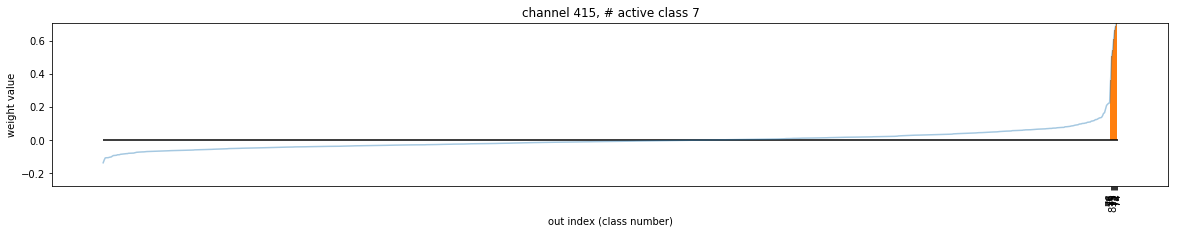

In [43]:
i = 0
n_samples = 10
sort_target = res_unique_lens[i]
target_weight = resnet34_weights[i]
vmin = target_weight.min()
vmax = target_weight.max()
sorted_channels = np.argsort(sort_target)[::-1]
for ch in np.concatenate((sorted_channels[:n_samples], sorted_channels[-n_samples:])):
    
    key = "{}-{}-{}".format(resnet34_model_names[i], key_layer, block_id)
    data0 = data_resnets[key][1][ch][0]
    data = target_weight[:, ch]
    
    plt.figure(figsize=(20, 3))
    msg = "channel {:03}, # active class {}".format(ch, sort_target[ch])
    plt.title(msg)
#     plt.bar(np.arange(len(data)), np.sort(data), width=1.0, alpha=0.4)
    plt.plot(np.arange(len(data)), np.sort(data), alpha=0.4)
    plt.hlines(y=0, xmin=0, xmax=n_classes)
    tmp_index = np.isin(np.argsort(data), data0)
    plt.bar(np.arange(len(data))[tmp_index], np.sort(data)[tmp_index], width=1.0, color="tab:orange")
    plt.xticks(ticks=np.arange(len(data))[tmp_index], labels=np.argsort(data)[tmp_index], rotation=90)
    plt.xlabel("out index (class number)")
    plt.ylabel("weight value")
    plt.ylim(vmin, vmax)
    plt.show()

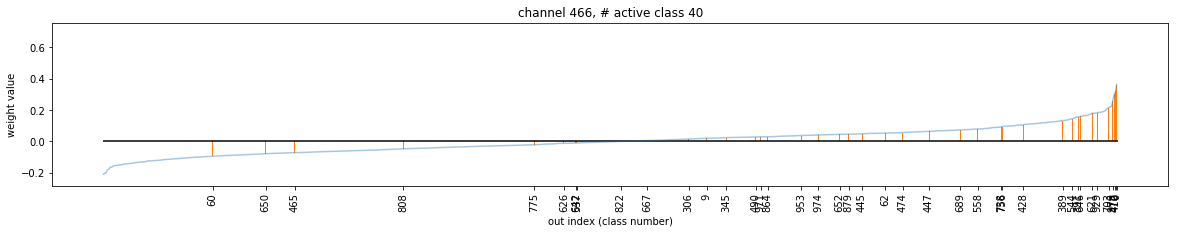

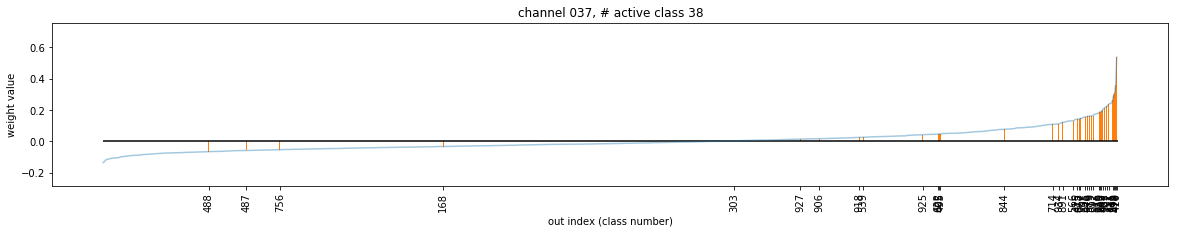

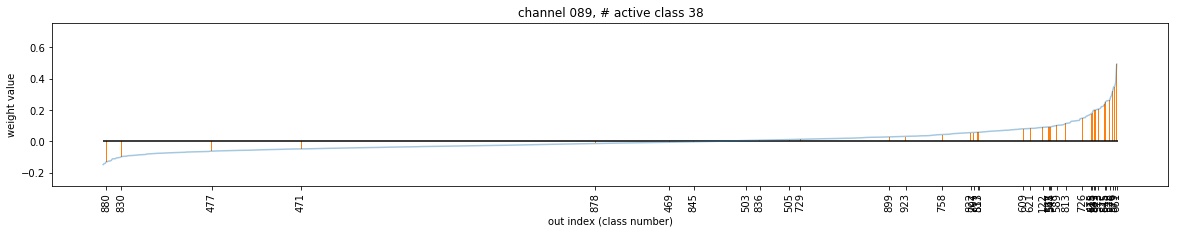

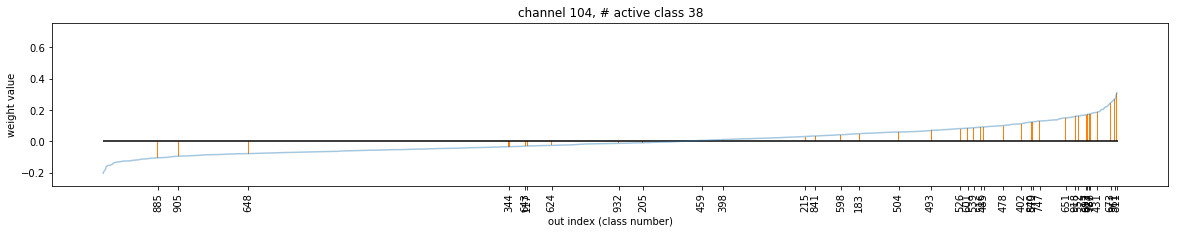

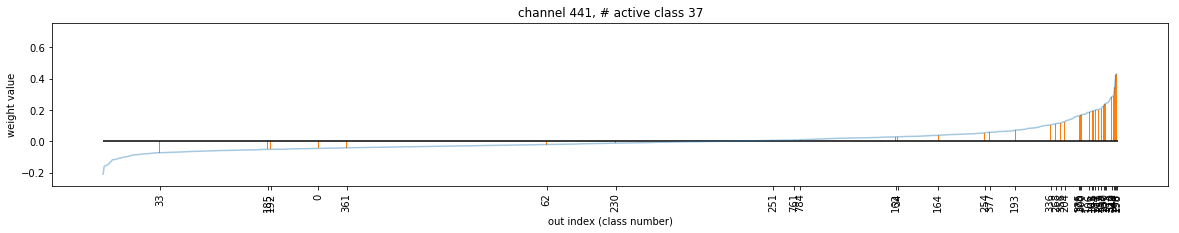

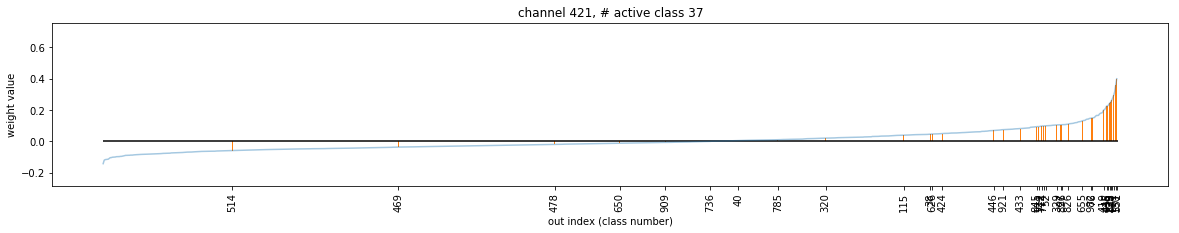

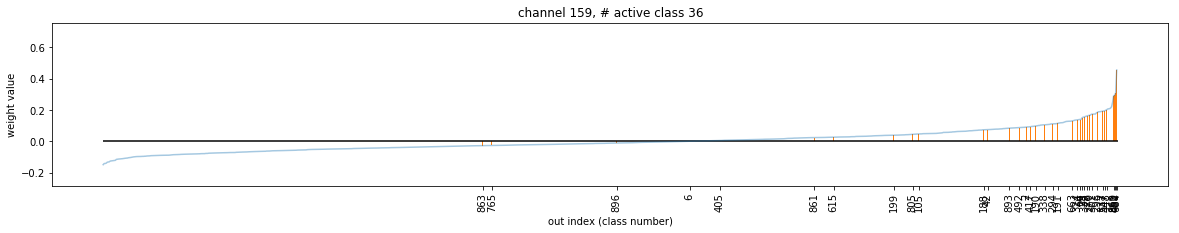

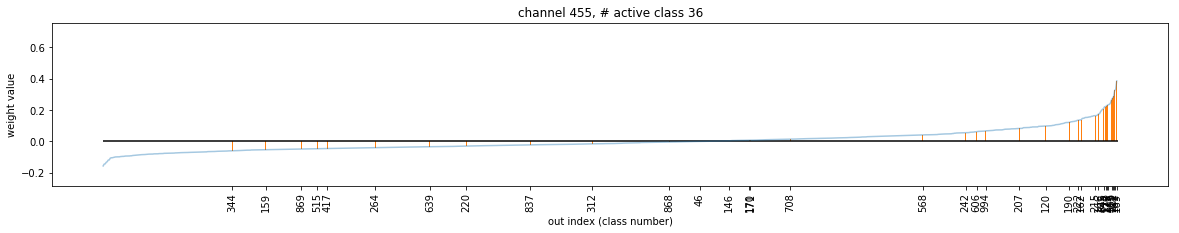

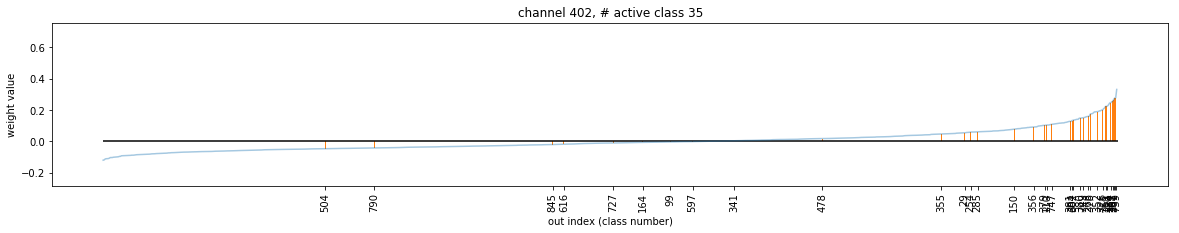

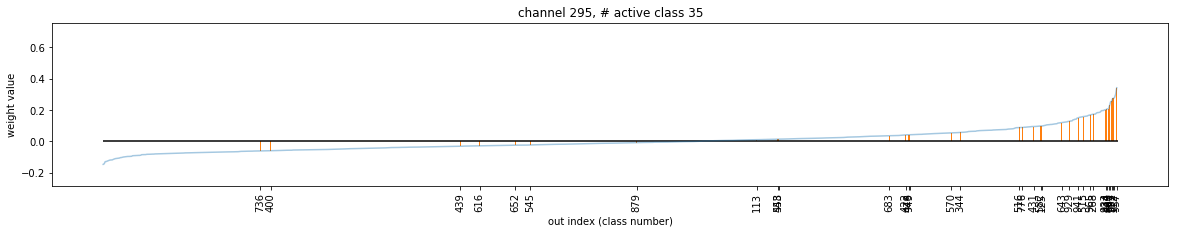

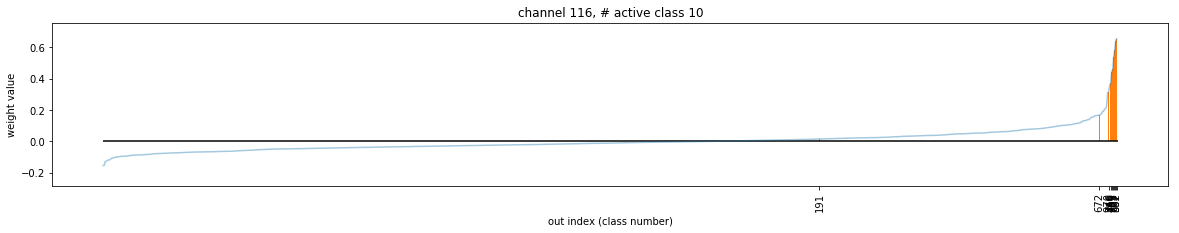

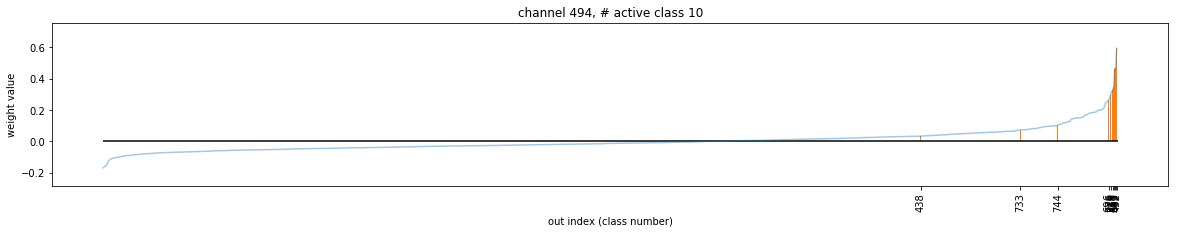

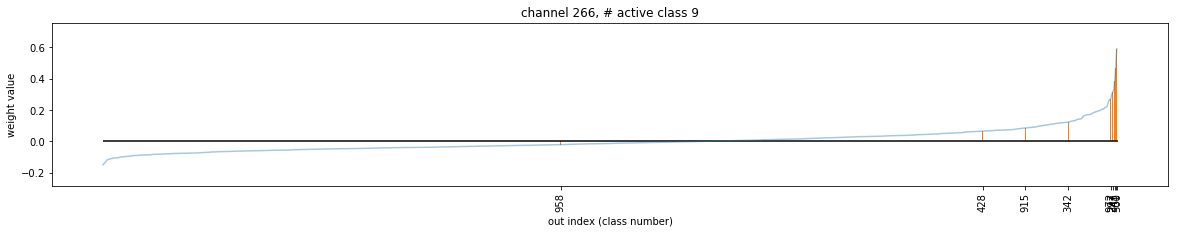

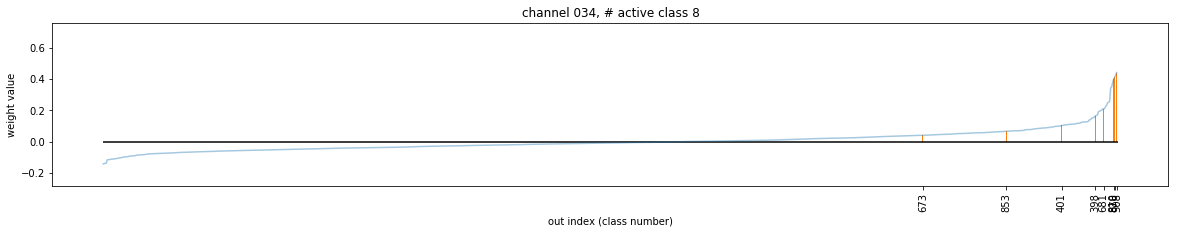

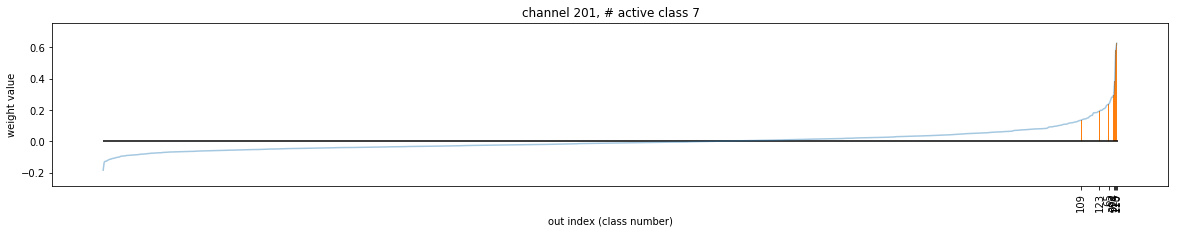

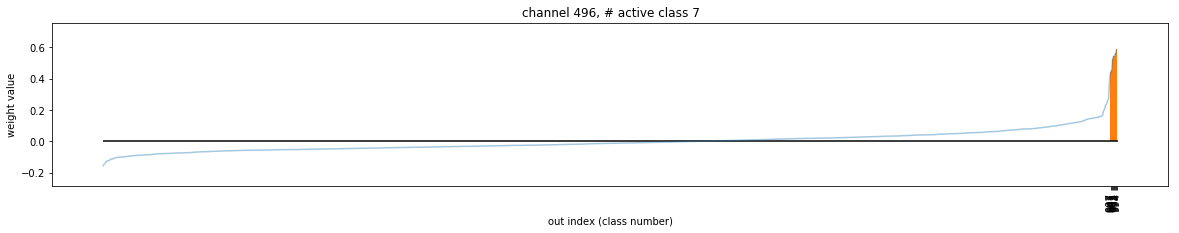

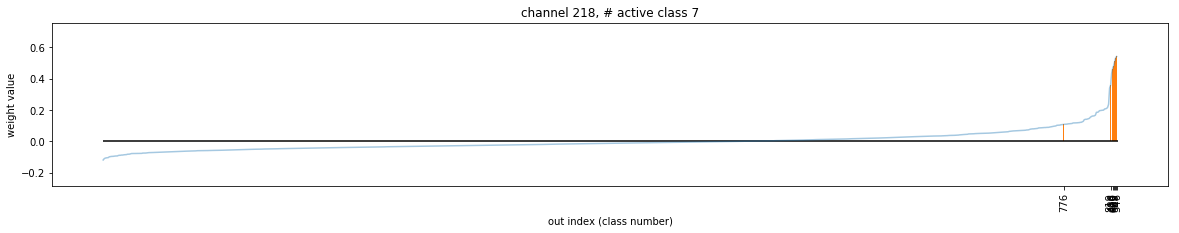

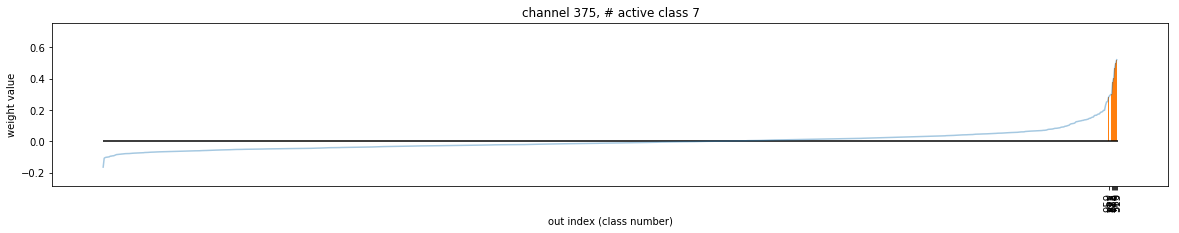

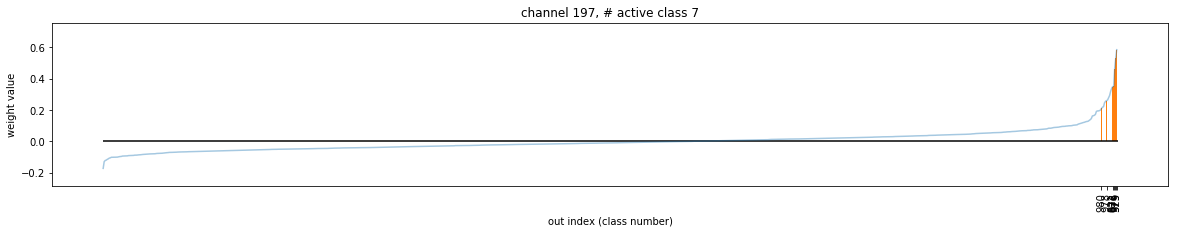

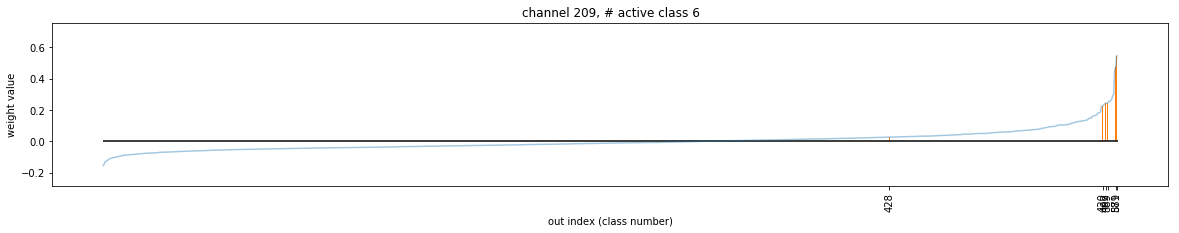

In [44]:
i = 0
n_samples = 10
sort_target = plain_unique_lens[i]
target_weight = plainnet34_weights[i]
vmin = target_weight.min()
vmax = target_weight.max()
sorted_channels = np.argsort(sort_target)[::-1]
for ch in np.concatenate((sorted_channels[:n_samples], sorted_channels[-n_samples:])):
    
    key = "{}-{}-{}".format(plainnet34_model_names[i], key_layer, block_id)
    data0 = data_plainnets[key][1][ch][0]
    data = target_weight[:, ch]
    
    plt.figure(figsize=(20, 3))
    msg = "channel {:03}, # active class {}".format(ch, sort_target[ch])
    plt.title(msg)
#     plt.bar(np.arange(len(data)), np.sort(data), width=1.0, alpha=0.4)
    plt.plot(np.arange(len(data)), np.sort(data), alpha=0.4)
    plt.hlines(y=0, xmin=0, xmax=n_classes)
    tmp_index = np.isin(np.argsort(data), data0)
    plt.bar(np.arange(len(data))[tmp_index], np.sort(data)[tmp_index], width=1.0, color="tab:orange")
    plt.xticks(ticks=np.arange(len(data))[tmp_index], labels=np.argsort(data)[tmp_index], rotation=90)
    plt.xlabel("out index (class number)")
    plt.ylabel("weight value")
    plt.ylim(vmin, vmax)
    plt.show()

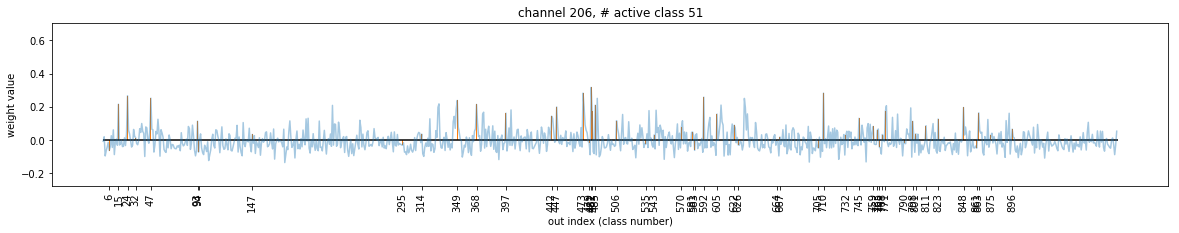

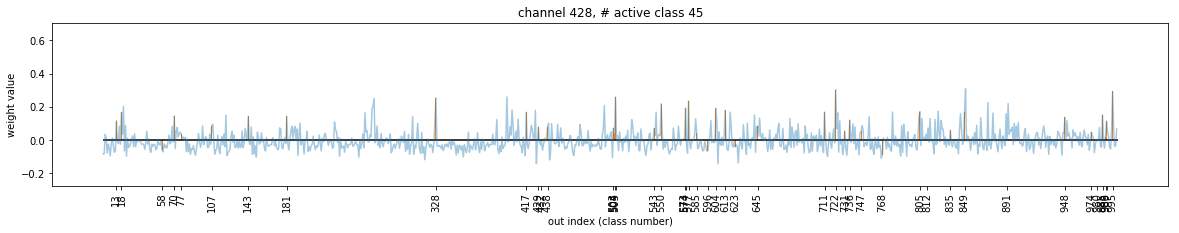

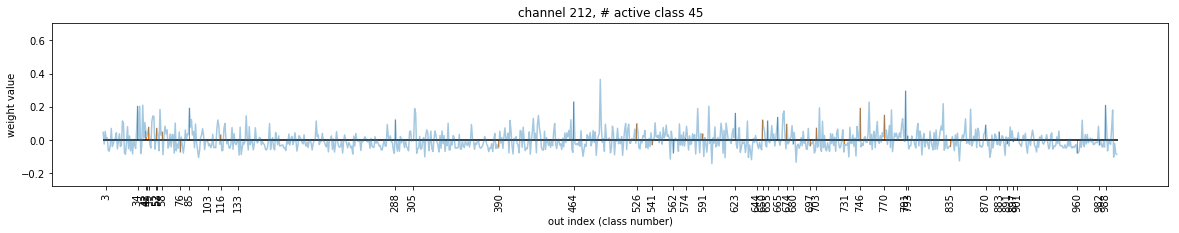

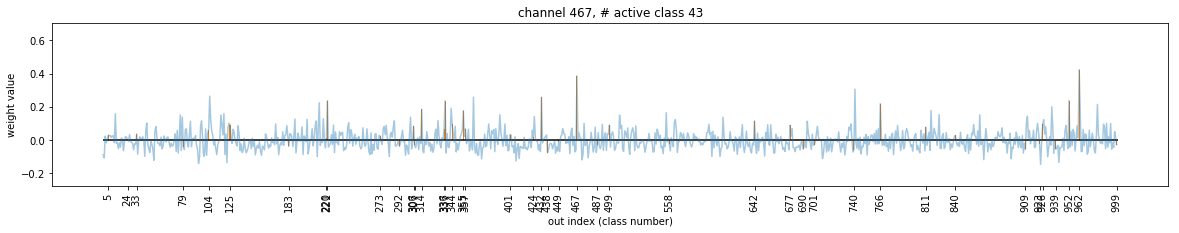

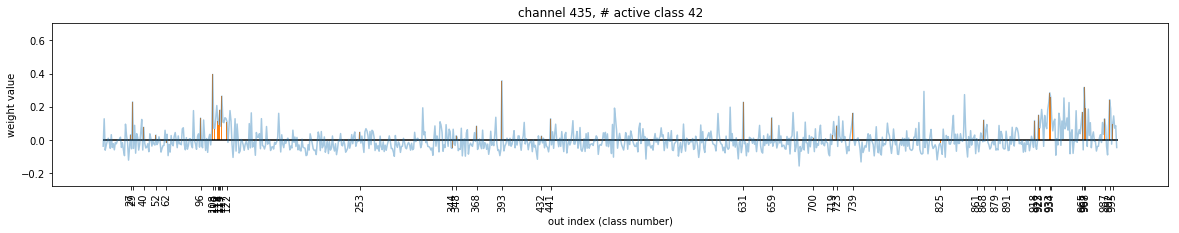

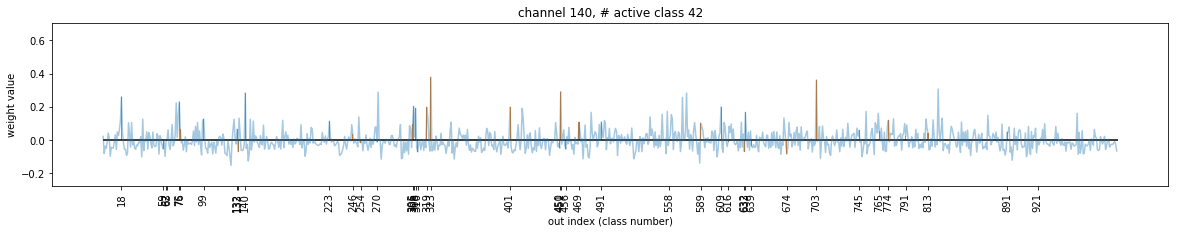

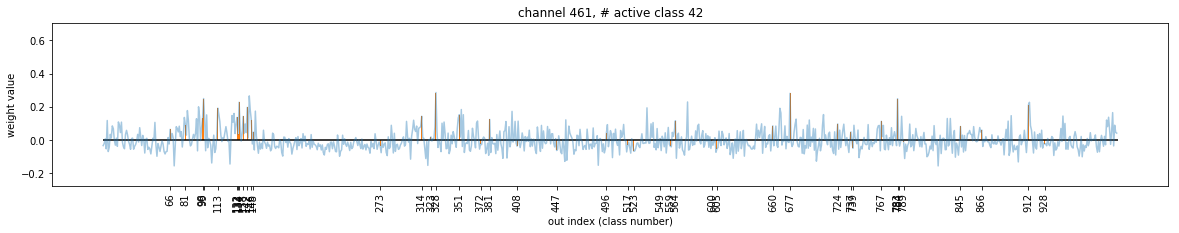

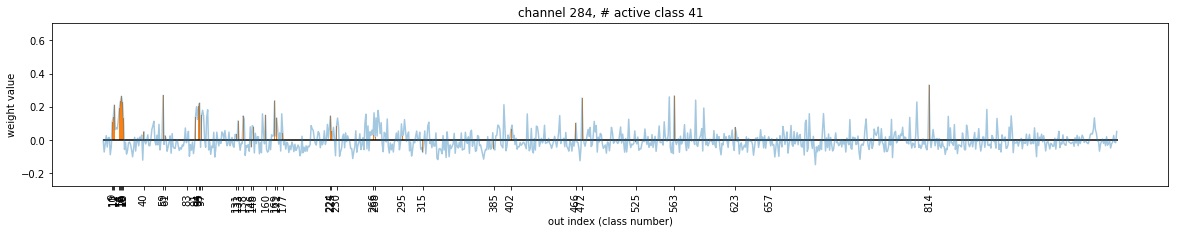

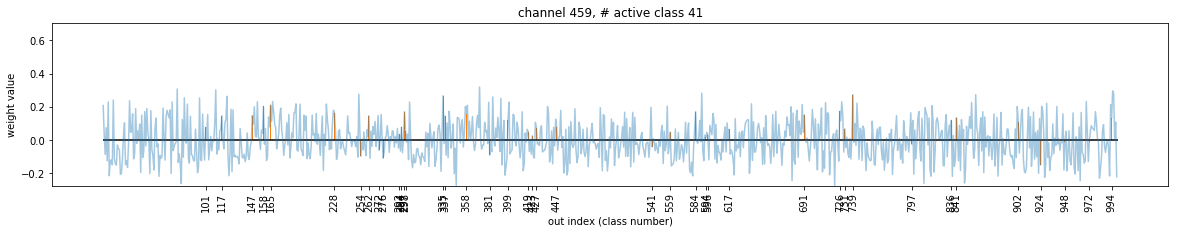

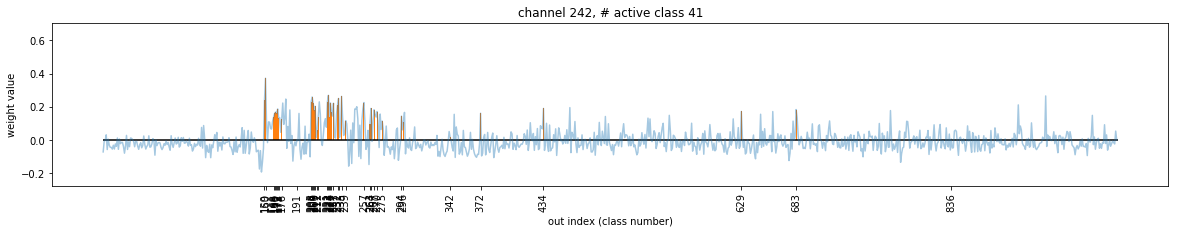

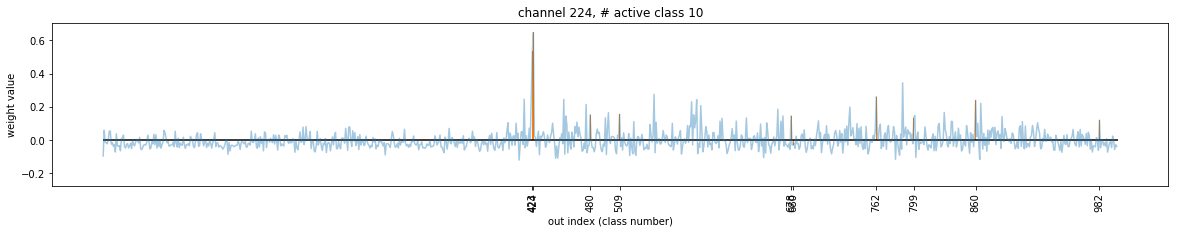

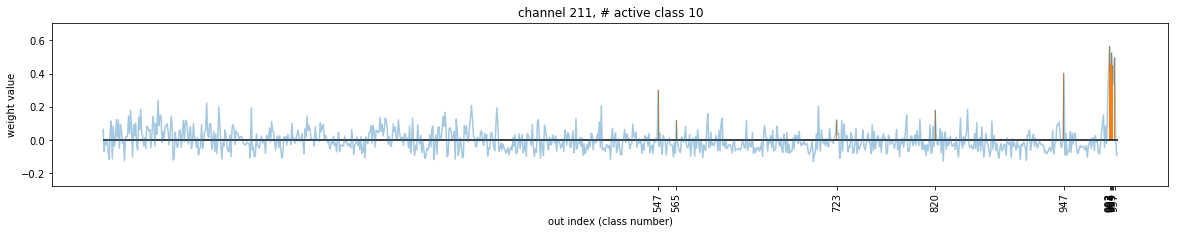

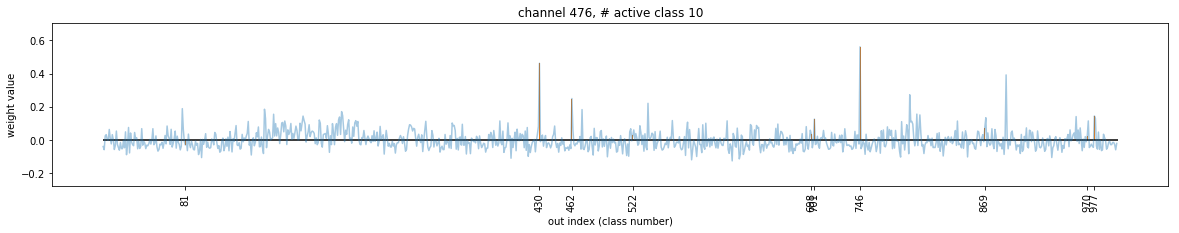

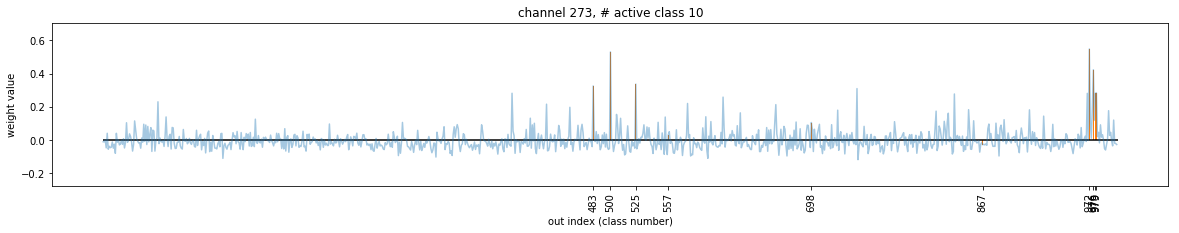

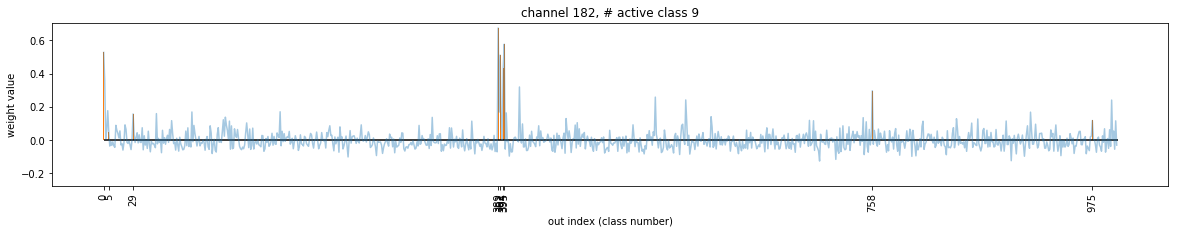

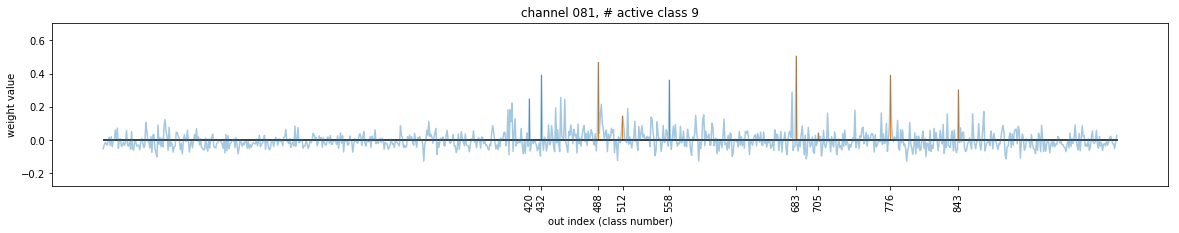

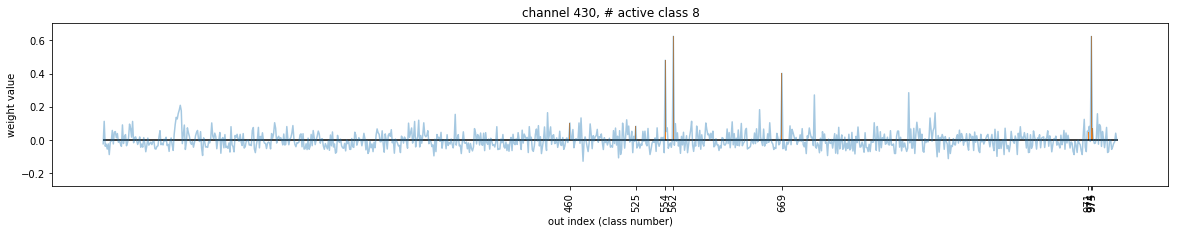

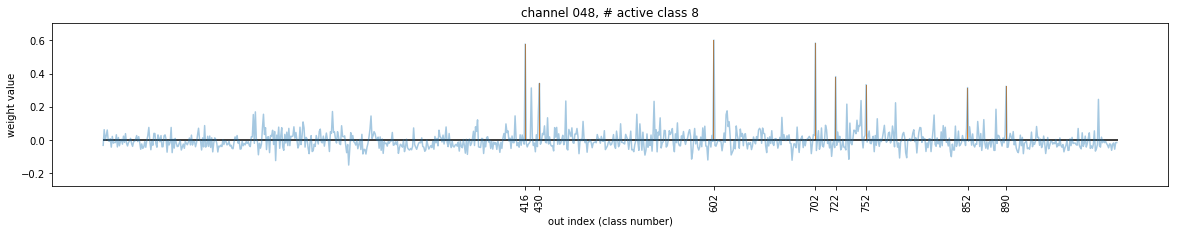

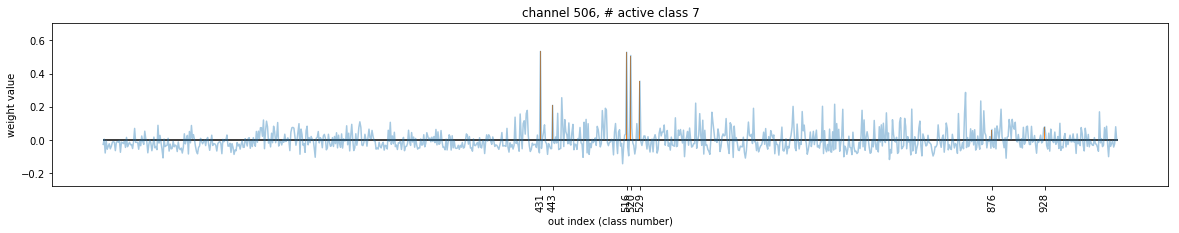

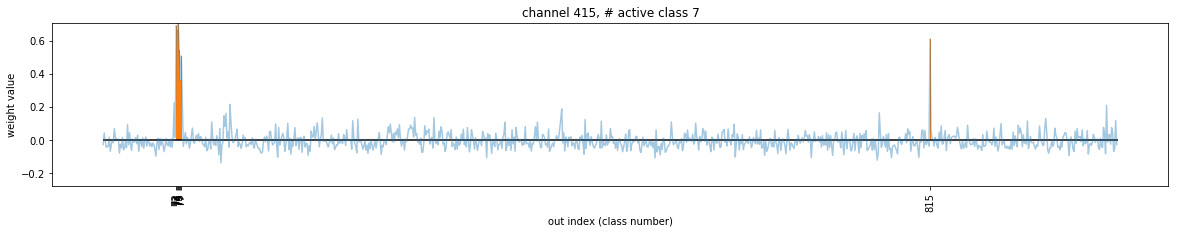

In [45]:
i = 0
n_samples = 10
sort_target = res_unique_lens[i]
target_weight = resnet34_weights[i]
vmin = target_weight.min()
vmax = target_weight.max()
sorted_channels = np.argsort(sort_target)[::-1]
for ch in np.concatenate((sorted_channels[:n_samples], sorted_channels[-n_samples:])):
    
    key = "{}-{}-{}".format(resnet34_model_names[i], key_layer, block_id)
    data0 = data_resnets[key][1][ch][0]
    data = target_weight[:, ch]
    
    plt.figure(figsize=(20, 3))
    msg = "channel {:03}, # active class {}".format(ch, sort_target[ch])
    plt.title(msg)
    plt.plot(np.arange(len(data)), data, alpha=0.4)
    plt.hlines(y=0, xmin=0, xmax=n_classes)
    tmp_index = data0
    plt.bar(np.arange(len(data))[tmp_index], data[tmp_index], width=1.0, color="tab:orange")
    plt.xticks(ticks=np.arange(len(data))[tmp_index], labels=data0, rotation=90)
    plt.xlabel("out index (class number)")
    plt.ylabel("weight value")
    plt.ylim(vmin, vmax)
    plt.show()

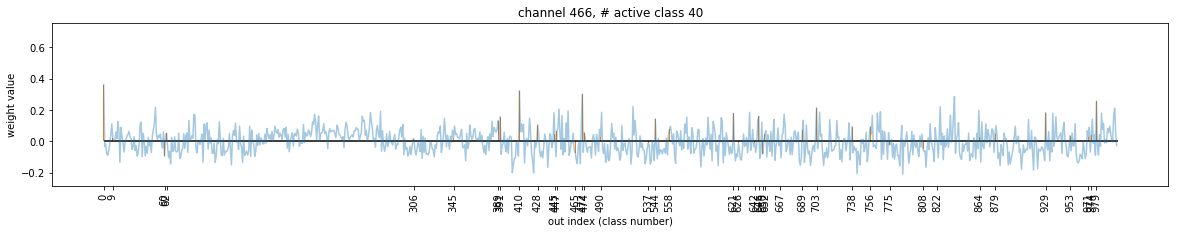

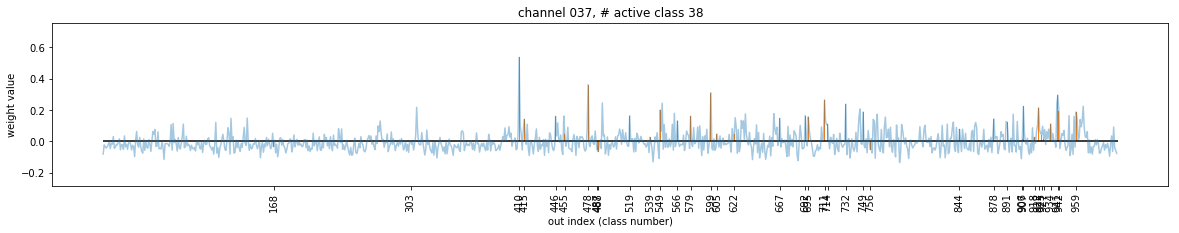

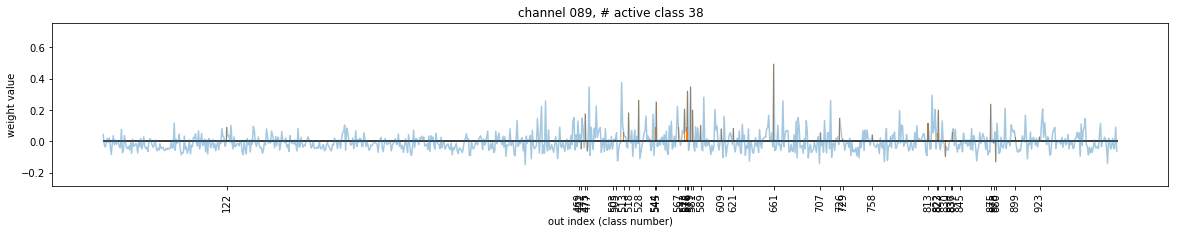

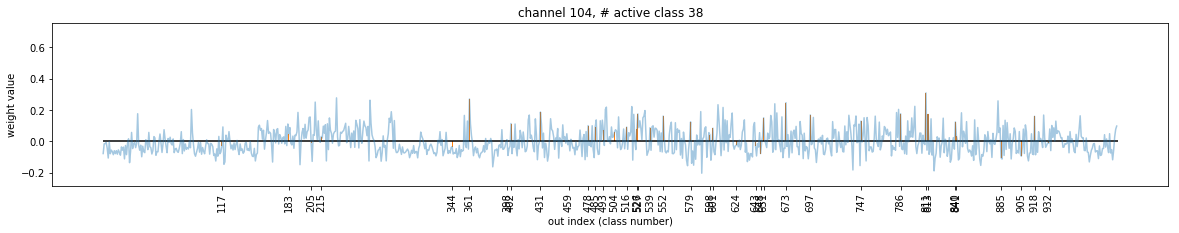

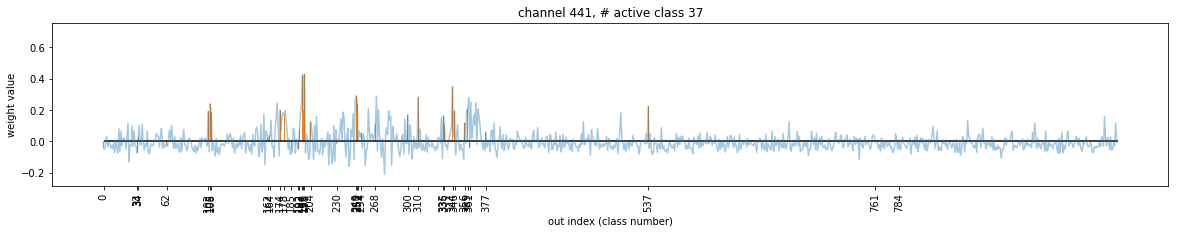

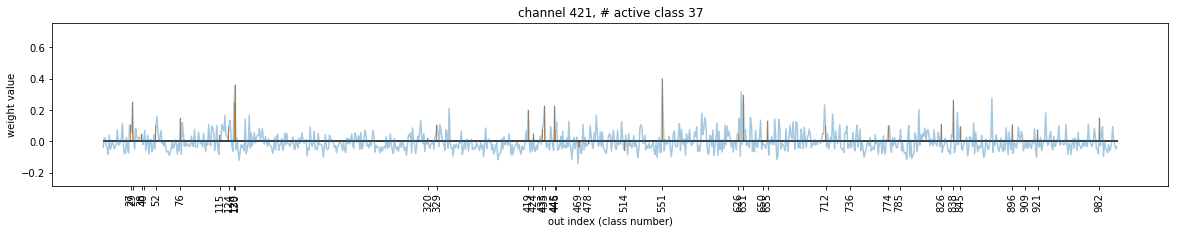

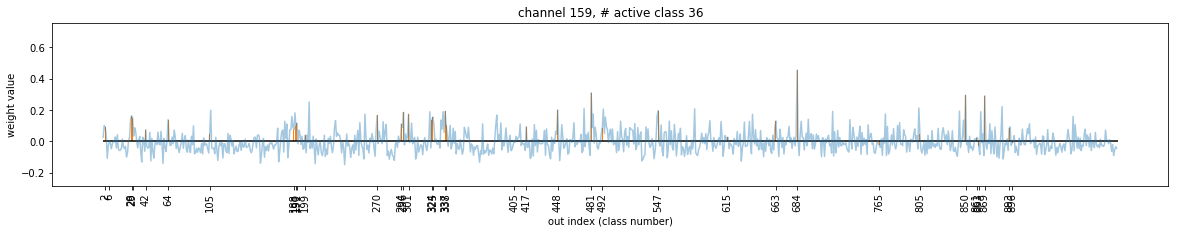

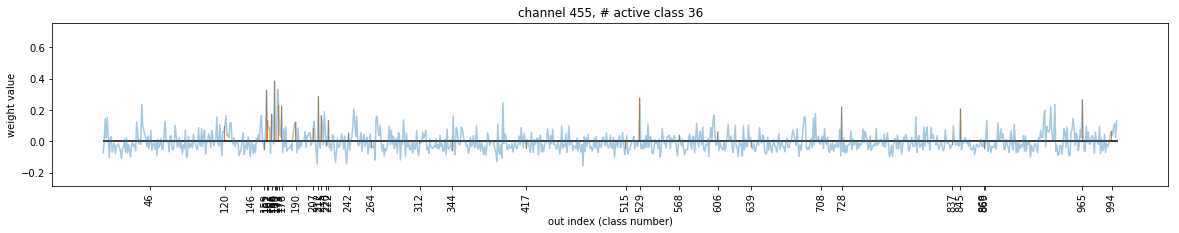

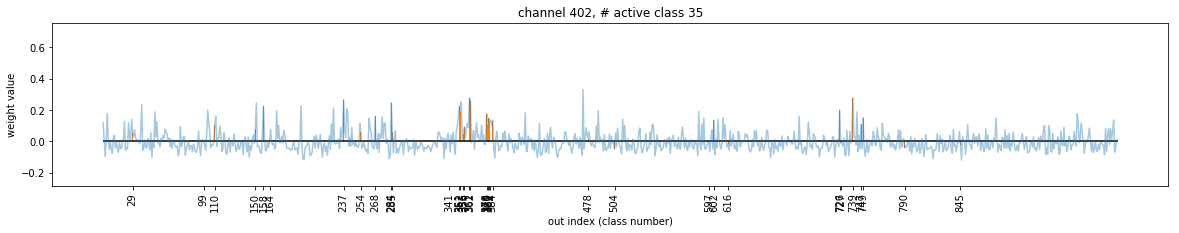

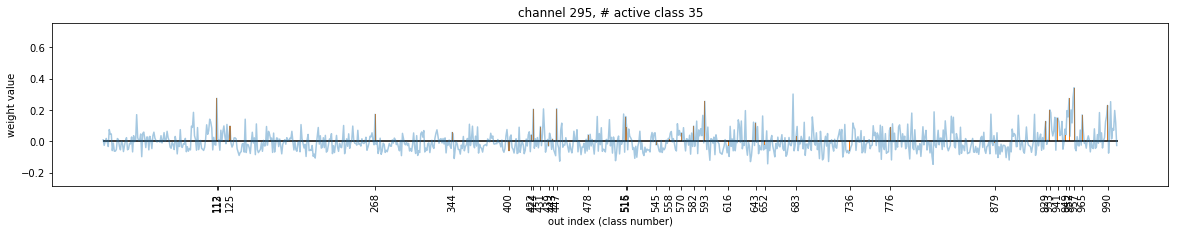

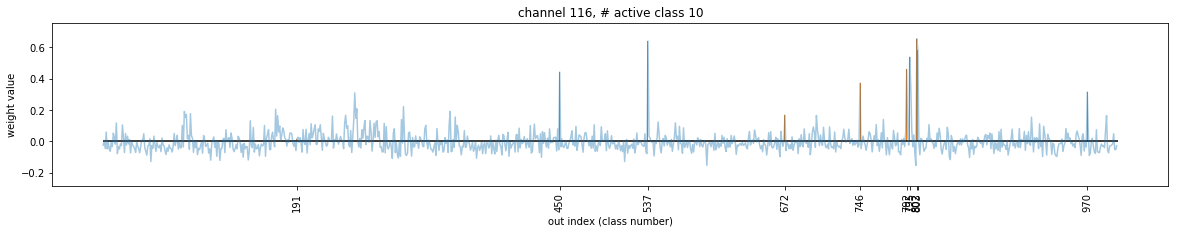

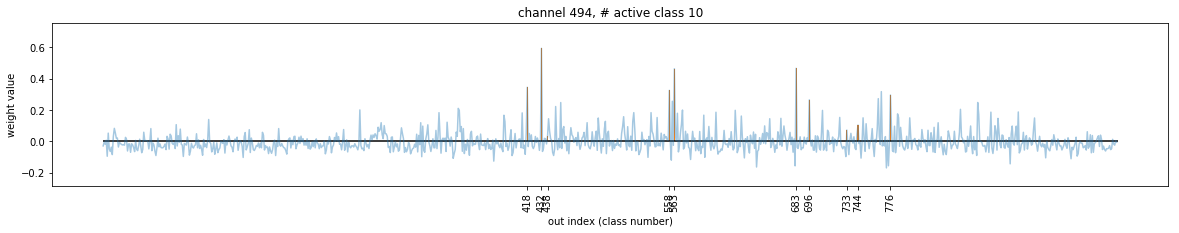

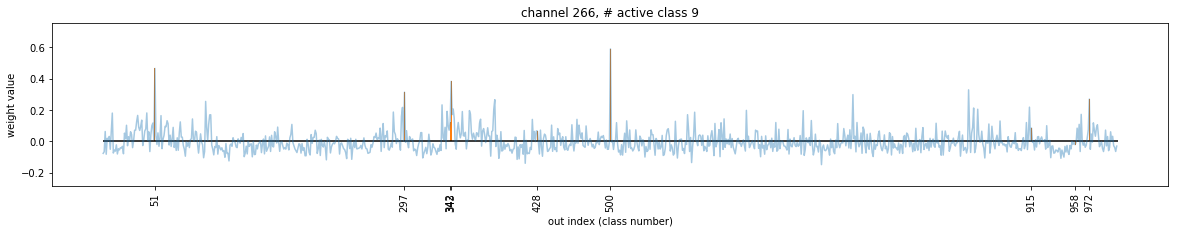

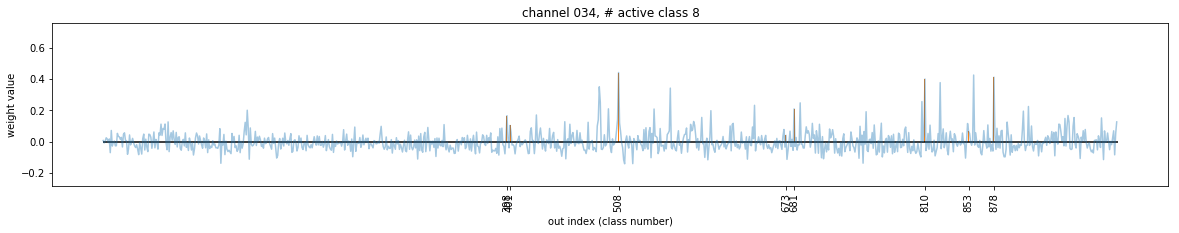

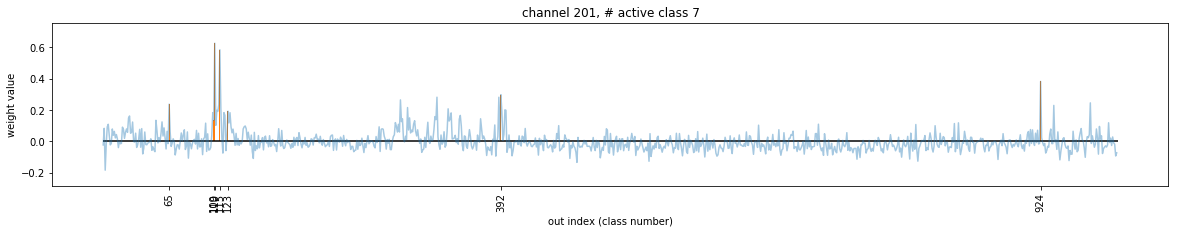

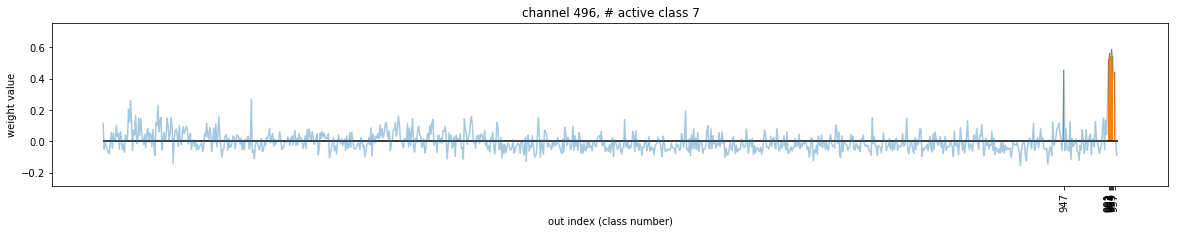

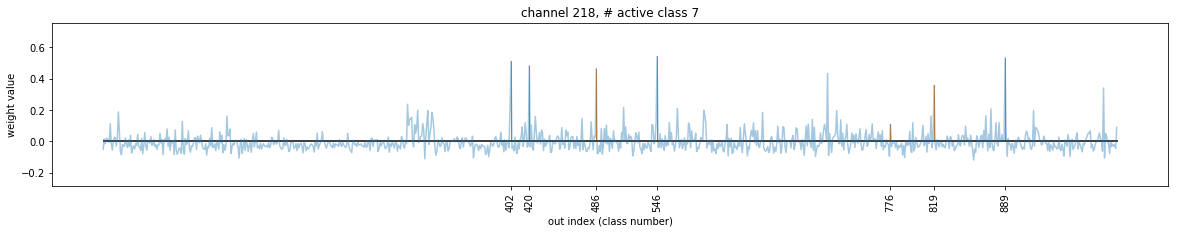

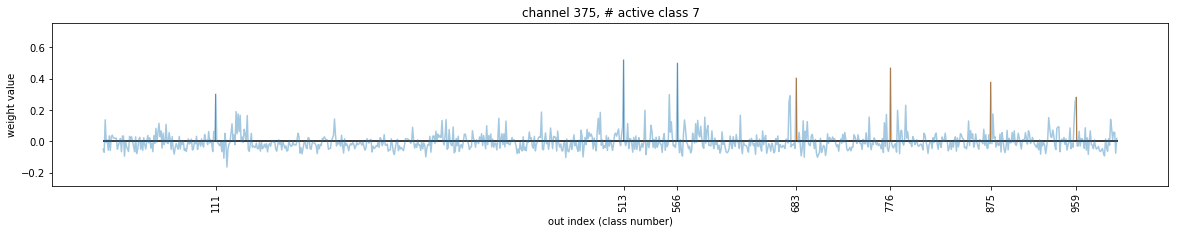

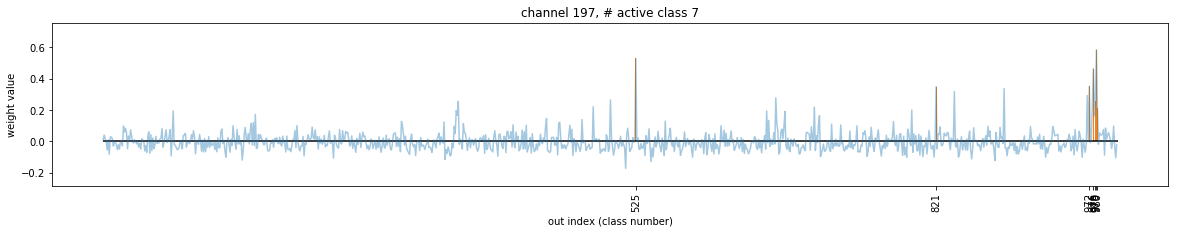

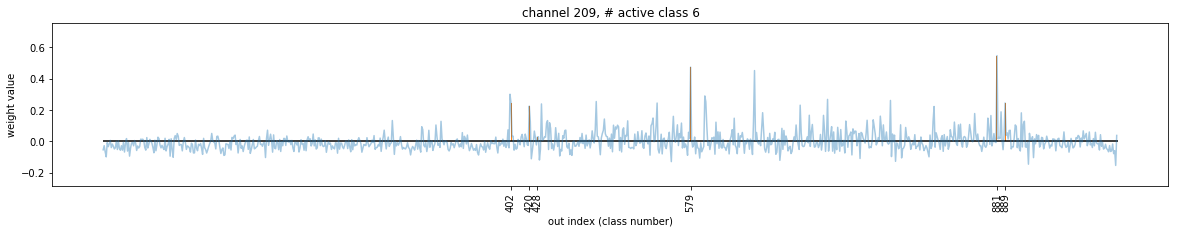

In [46]:
i = 0
n_samples = 10
sort_target = plain_unique_lens[i]
target_weight = plainnet34_weights[i]
vmin = target_weight.min()
vmax = target_weight.max()
sorted_channels = np.argsort(sort_target)[::-1]
for ch in np.concatenate((sorted_channels[:n_samples], sorted_channels[-n_samples:])):
    
    key = "{}-{}-{}".format(plainnet34_model_names[i], key_layer, block_id)
    data0 = data_plainnets[key][1][ch][0]
    data = target_weight[:, ch]
    
    plt.figure(figsize=(20, 3))
    msg = "channel {:03}, # active class {}".format(ch, sort_target[ch])
    plt.title(msg)
    plt.plot(np.arange(len(data)), data, alpha=0.4)
    plt.hlines(y=0, xmin=0, xmax=n_classes)
    tmp_index = data0
    plt.bar(np.arange(len(data))[tmp_index], data[tmp_index], width=1.0, color="tab:orange")
    plt.xticks(ticks=np.arange(len(data))[tmp_index], labels=data0, rotation=90)
    plt.xlabel("out index (class number)")
    plt.ylabel("weight value")
    plt.ylim(vmin, vmax)
    plt.show()

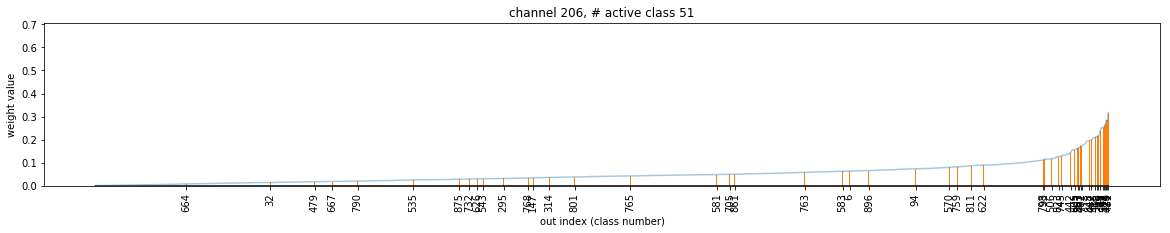

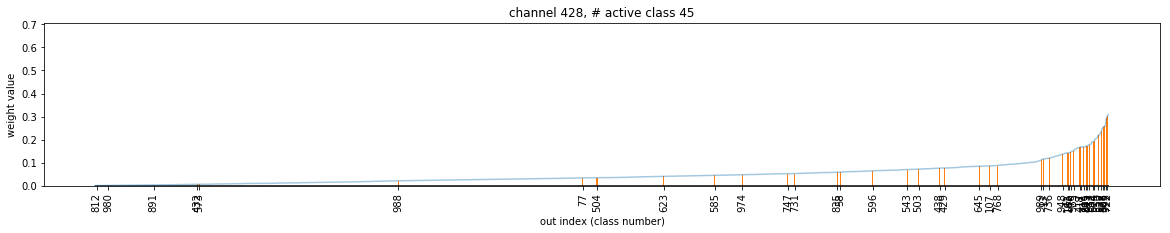

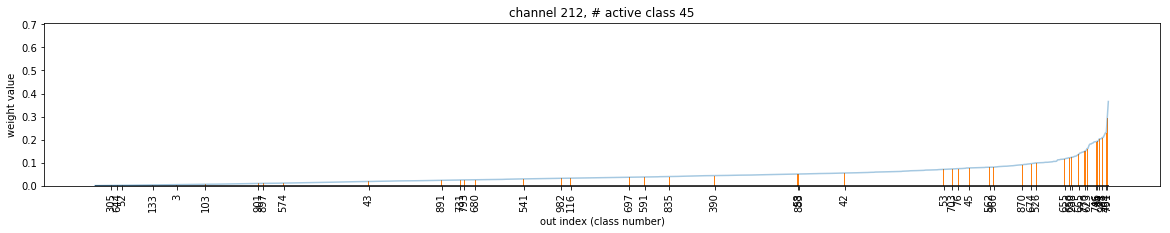

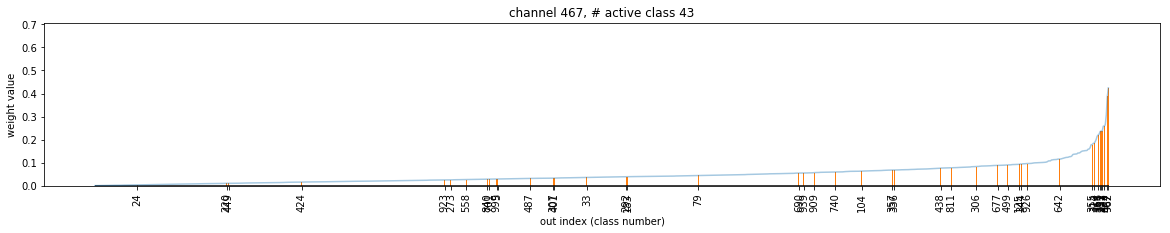

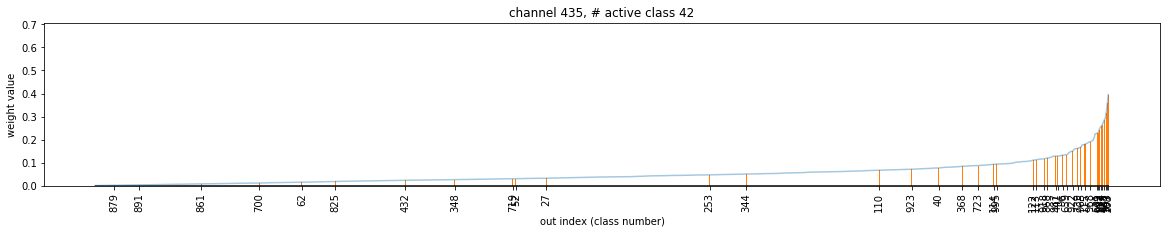

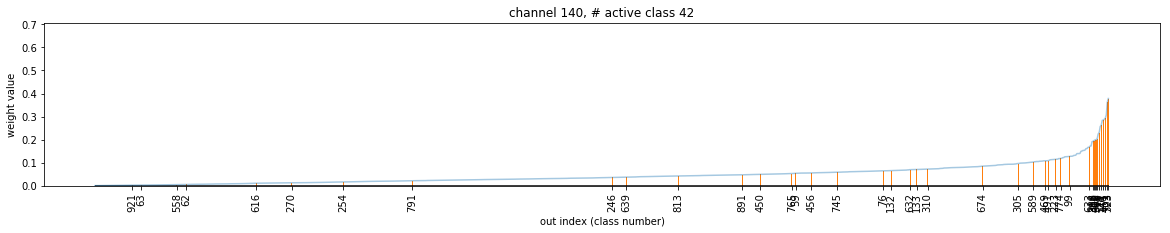

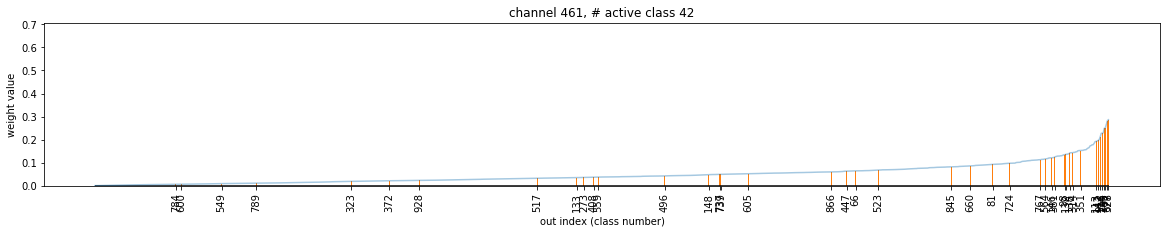

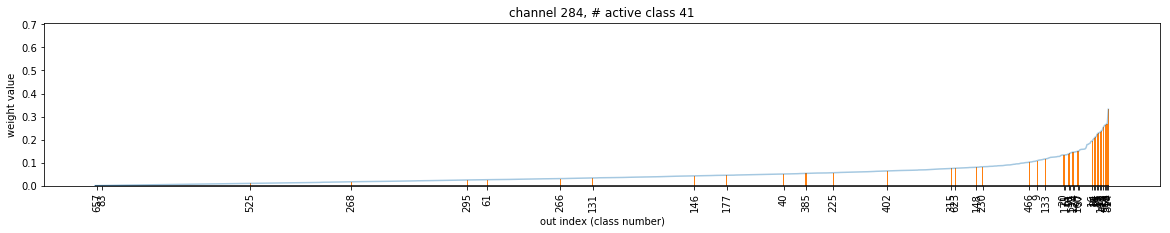

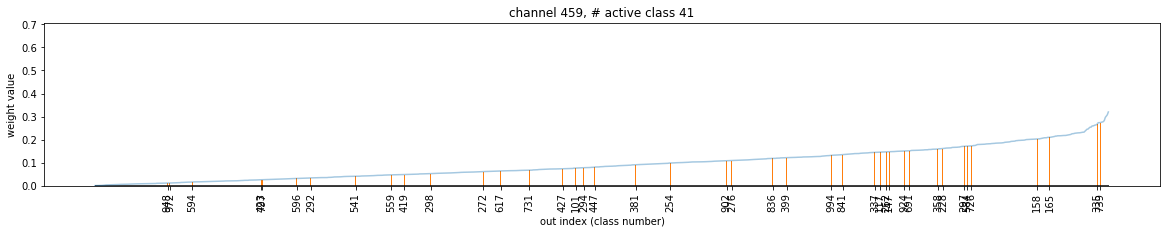

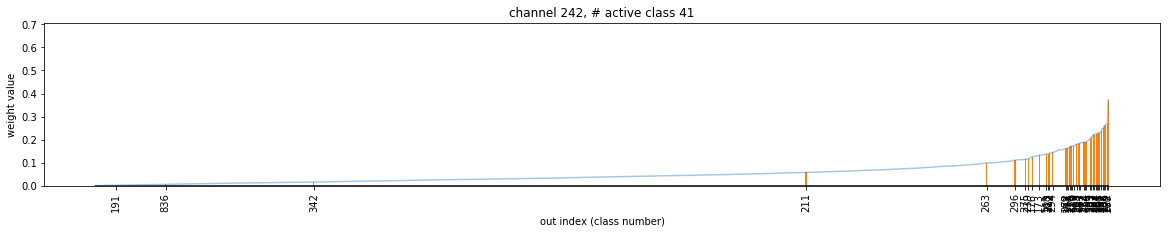

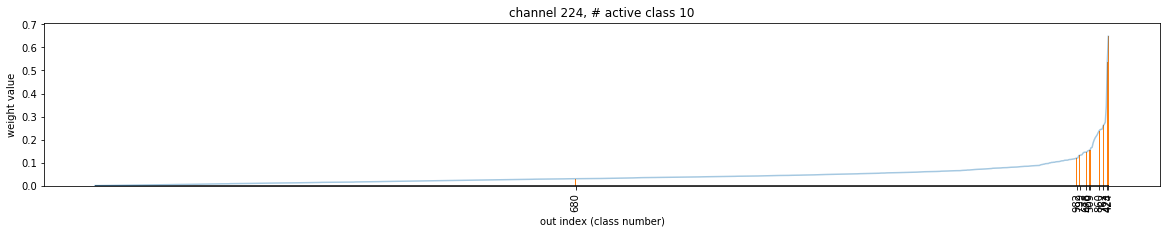

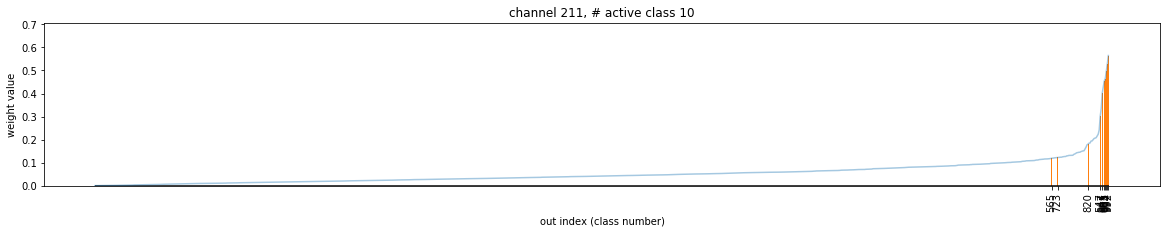

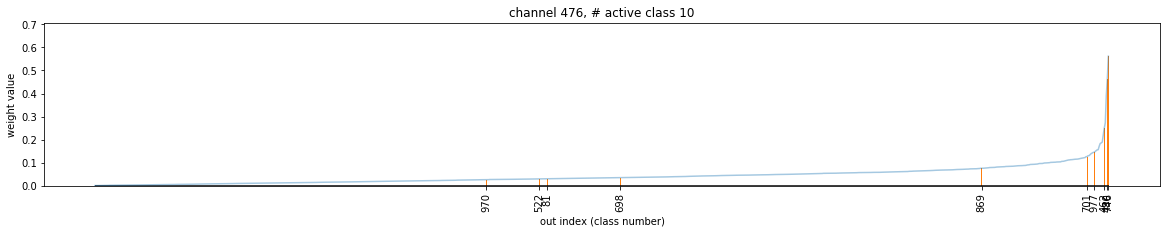

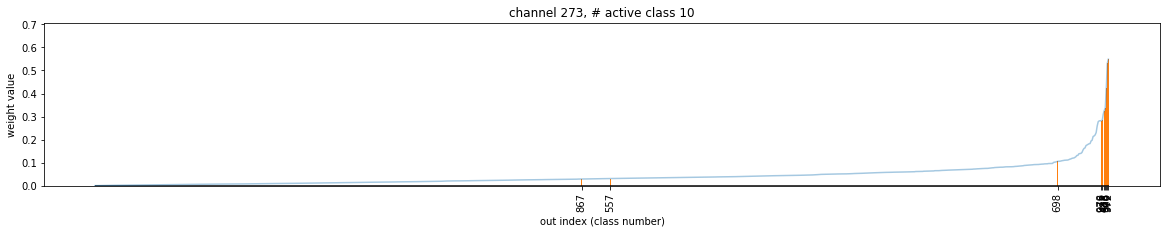

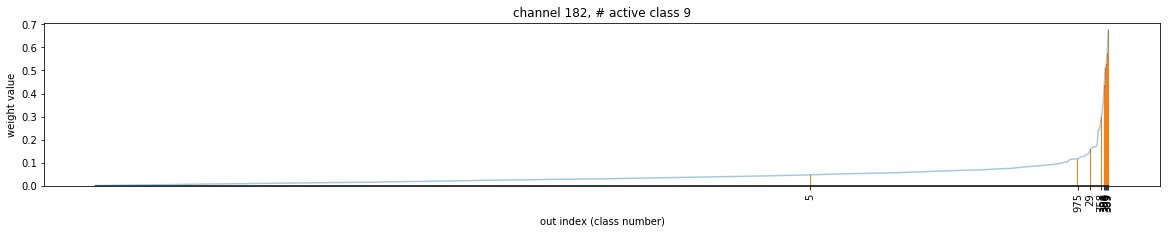

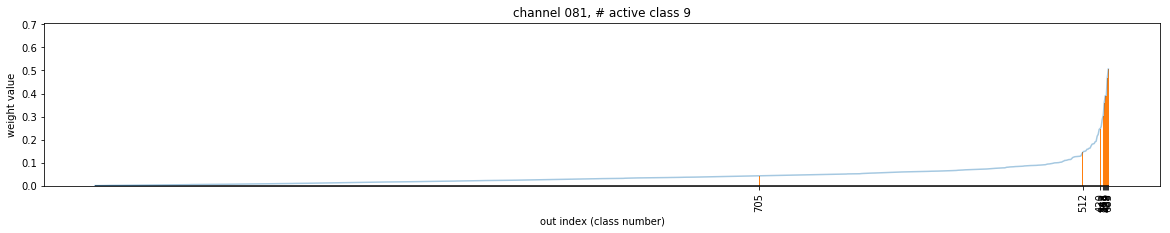

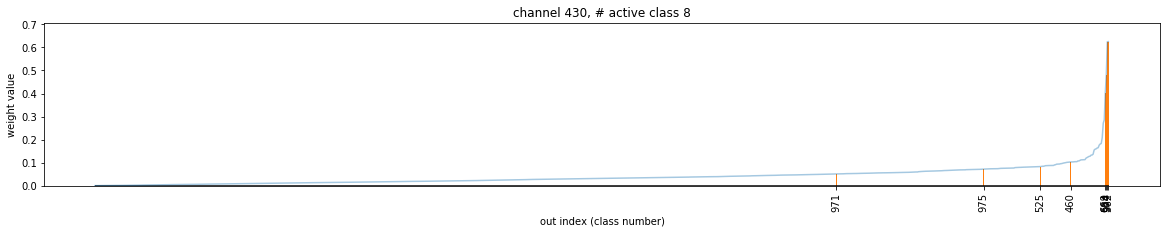

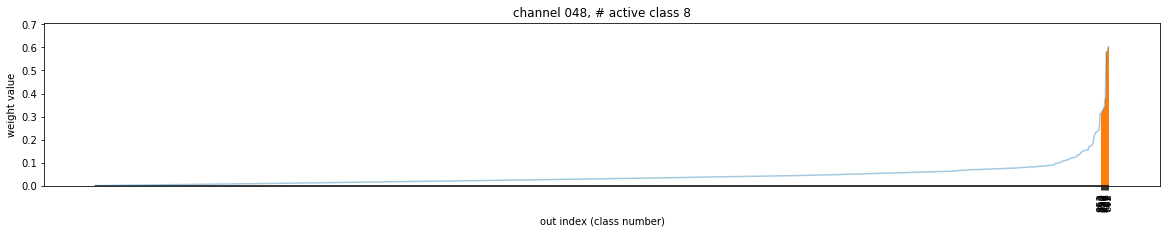

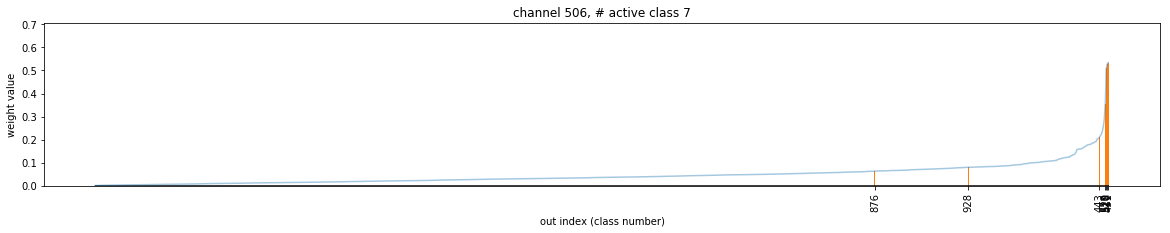

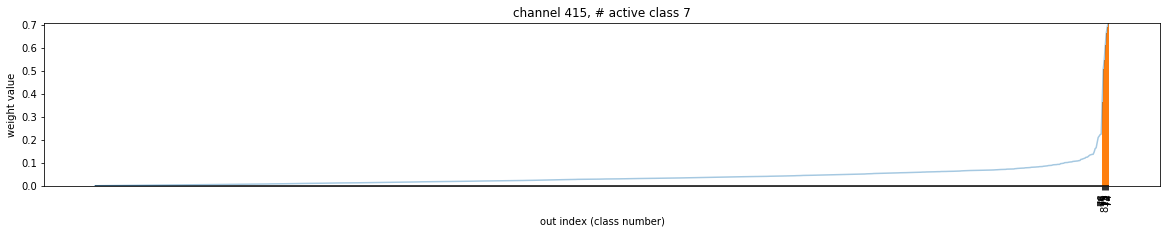

In [47]:
i = 0
n_samples = 10
sort_target = res_unique_lens[i]
target_weight = resnet34_weights[i]
vmin = target_weight.min()
vmax = target_weight.max()
sorted_channels = np.argsort(sort_target)[::-1]
for ch in np.concatenate((sorted_channels[:n_samples], sorted_channels[-n_samples:])):
    
    key = "{}-{}-{}".format(resnet34_model_names[i], key_layer, block_id)
    data0 = data_resnets[key][1][ch][0]
    data = target_weight[:, ch]
    
    plt.figure(figsize=(20, 3))
    msg = "channel {:03}, # active class {}".format(ch, sort_target[ch])
    plt.title(msg)
    plt.plot(np.arange(len(data)), np.sort(np.abs(data)), alpha=0.4)
    plt.hlines(y=0, xmin=0, xmax=n_classes)
    tmp_index = np.isin(np.argsort(np.abs(data)), data0)
    plt.bar(np.arange(len(data))[tmp_index], np.sort(np.abs(data))[tmp_index], width=1.0, color="tab:orange")
    plt.xticks(ticks=np.arange(len(data))[tmp_index], labels=np.argsort(np.abs(data))[tmp_index], rotation=90)
    plt.xlabel("out index (class number)")
    plt.ylabel("weight value")
    plt.ylim(0, np.maximum(vmax, np.abs(vmin)))
    plt.show()

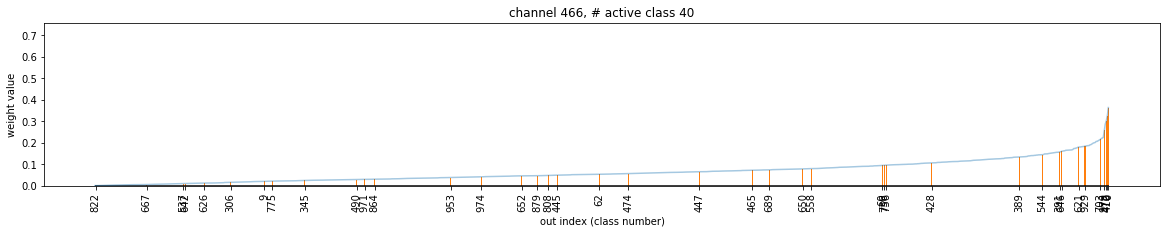

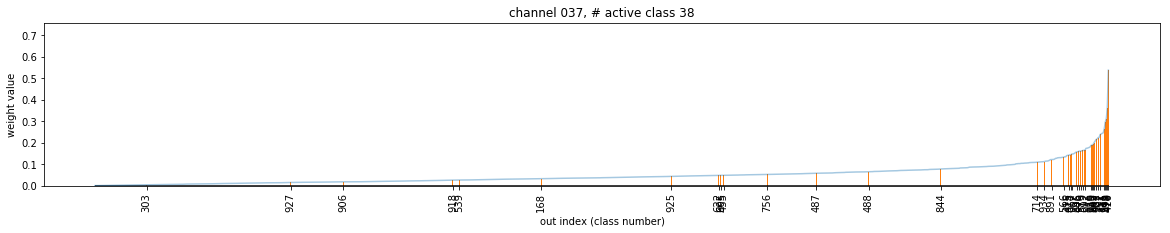

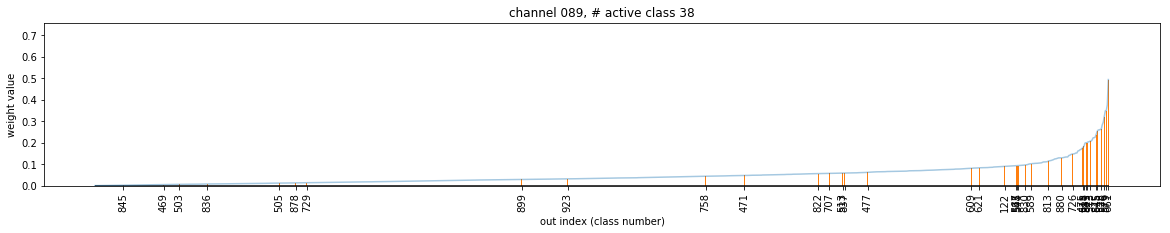

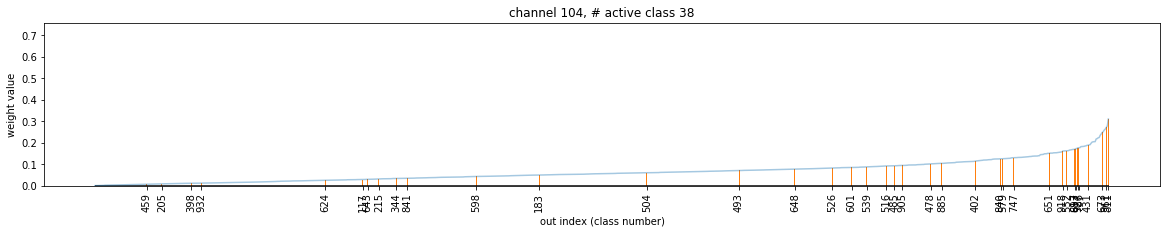

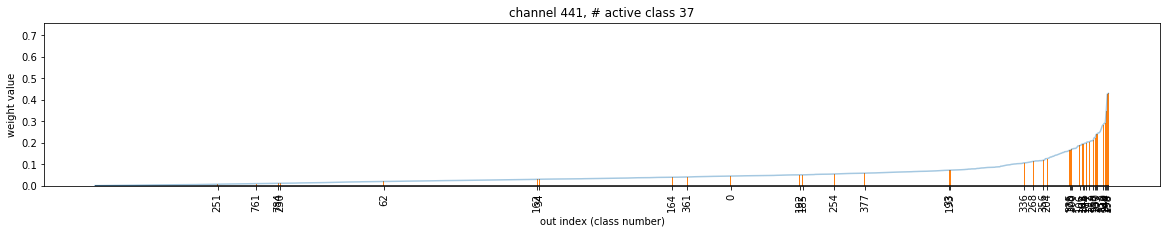

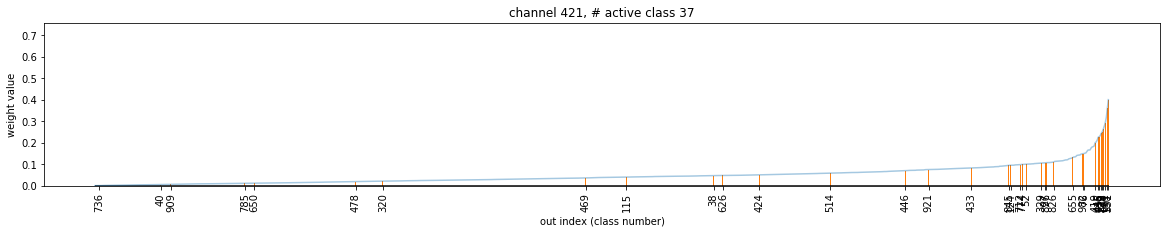

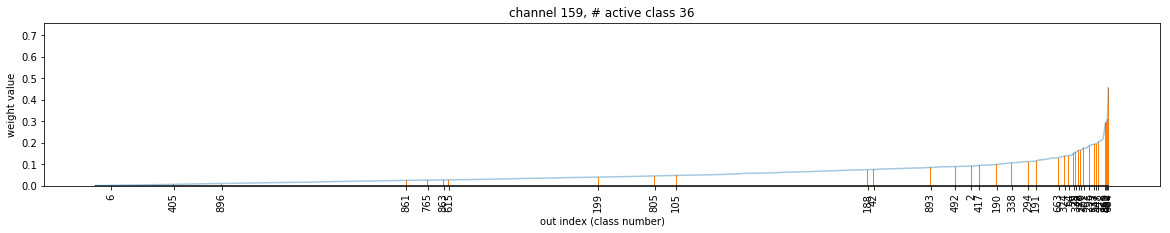

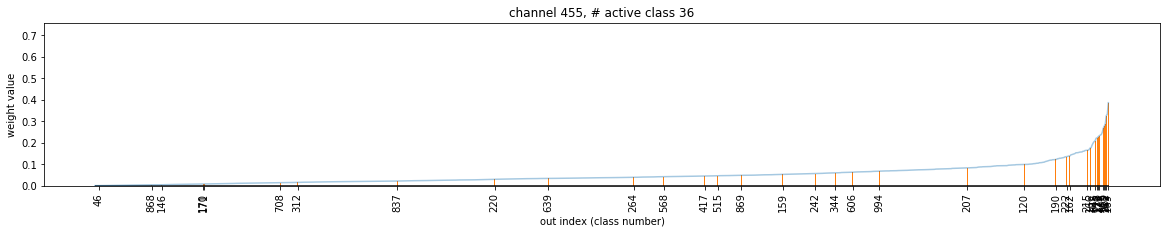

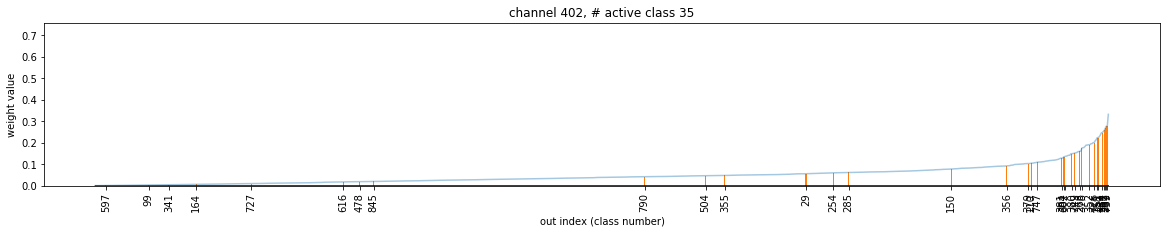

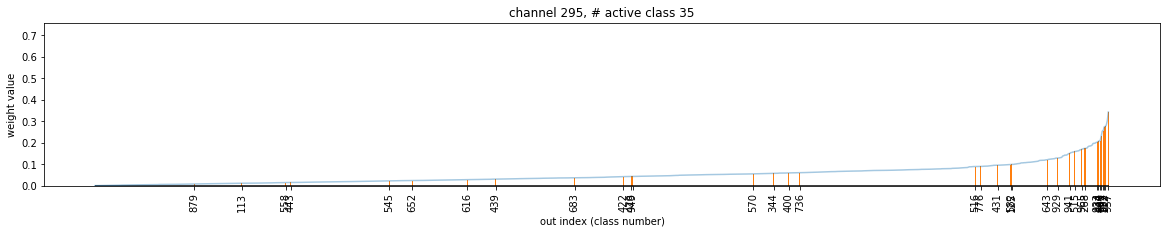

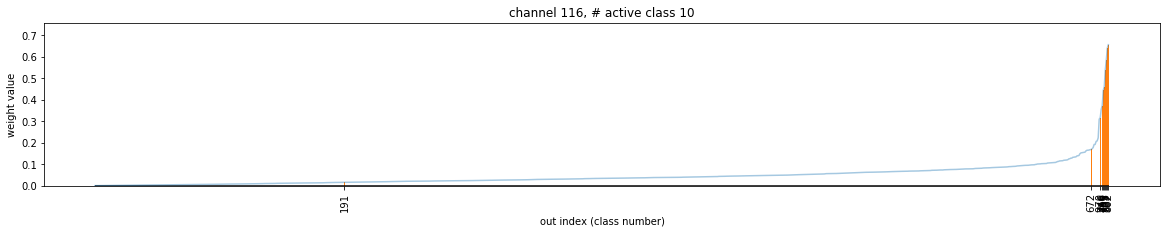

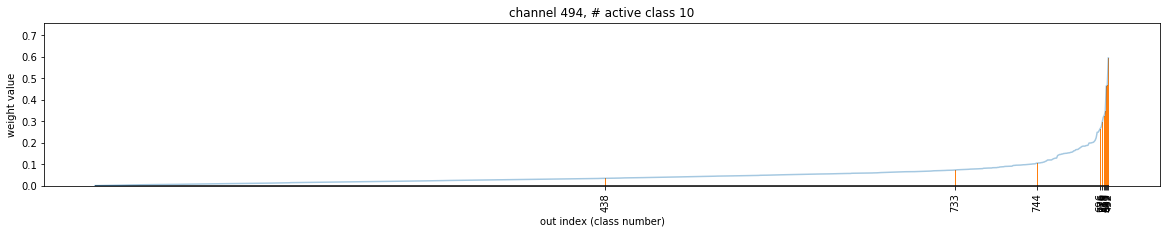

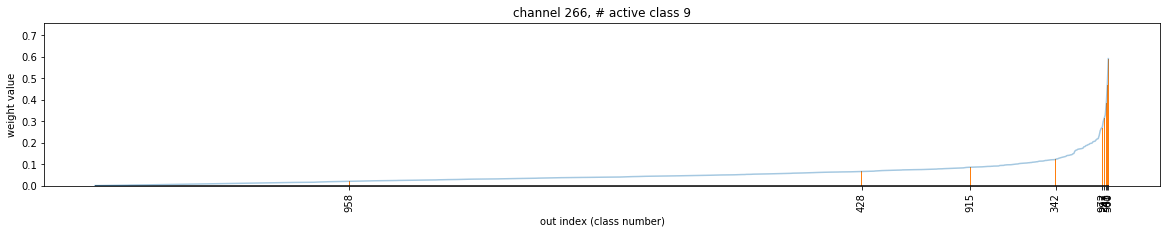

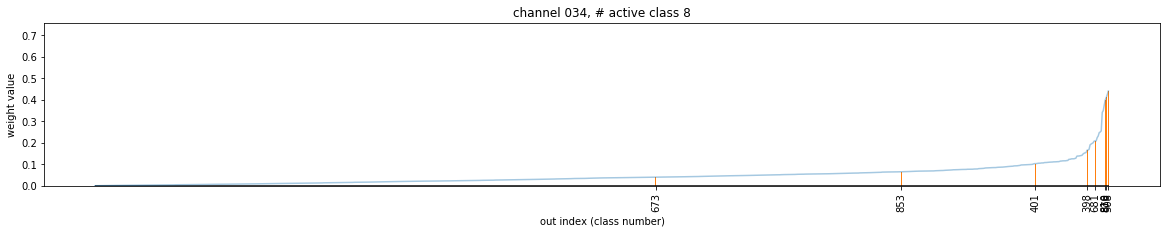

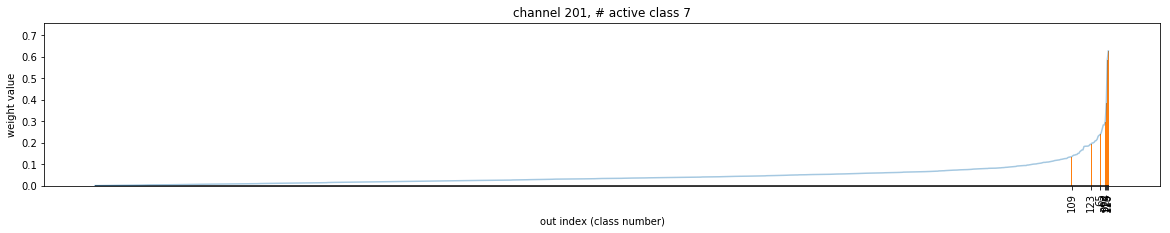

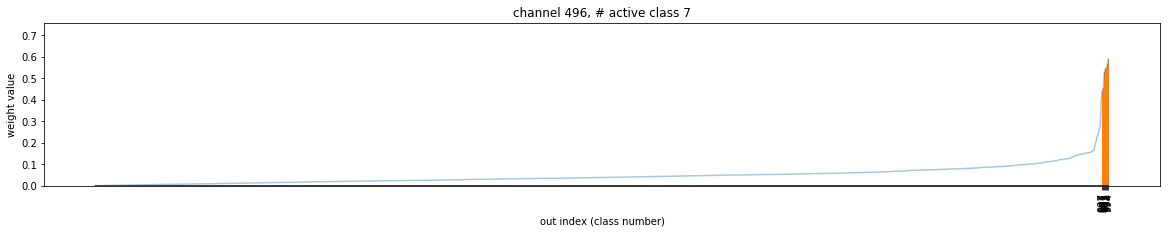

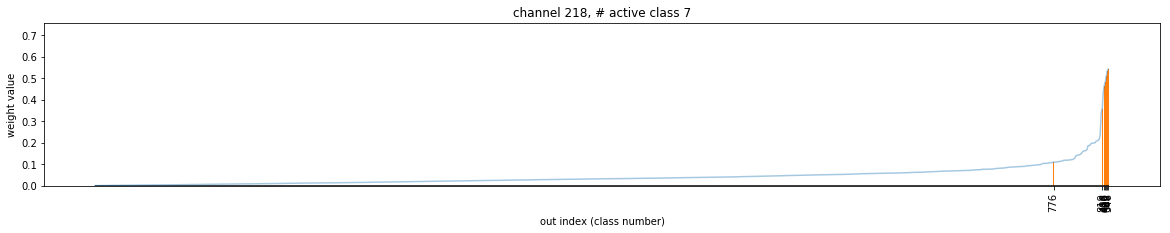

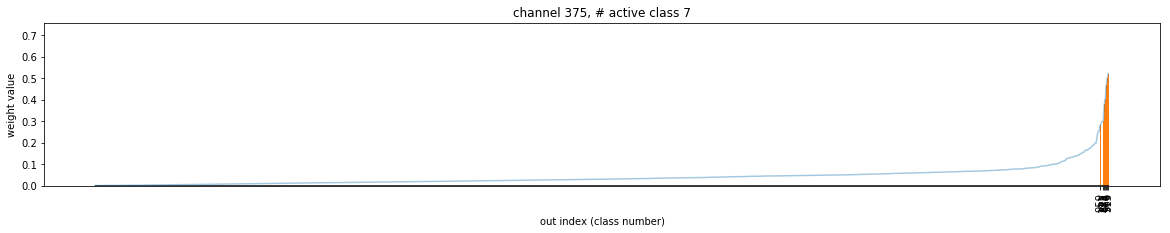

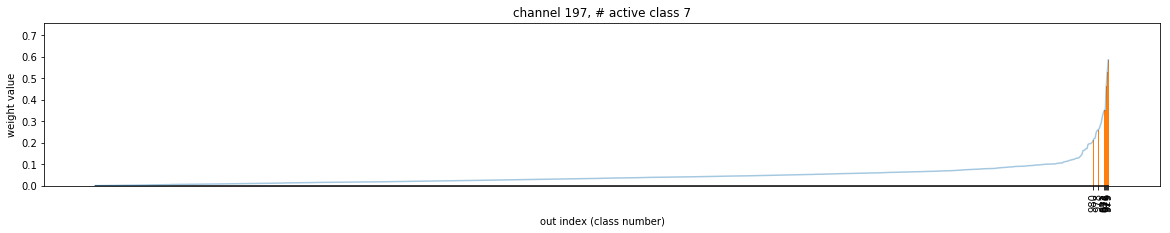

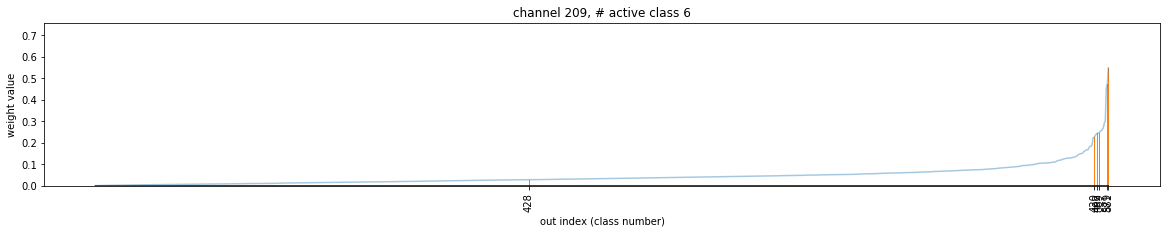

In [48]:
i = 0
n_samples = 10
sort_target = plain_unique_lens[i]
target_weight = plainnet34_weights[i]
vmin = target_weight.min()
vmax = target_weight.max()
sorted_channels = np.argsort(sort_target)[::-1]
for ch in np.concatenate((sorted_channels[:n_samples], sorted_channels[-n_samples:])):
    
    key = "{}-{}-{}".format(plainnet34_model_names[i], key_layer, block_id)
    data0 = data_plainnets[key][1][ch][0]
    data = target_weight[:, ch]
    
    plt.figure(figsize=(20, 3))
    msg = "channel {:03}, # active class {}".format(ch, sort_target[ch])
    plt.title(msg)
    plt.plot(np.arange(len(data)), np.sort(np.abs(data)), alpha=0.4)
    plt.hlines(y=0, xmin=0, xmax=n_classes)
    tmp_index = np.isin(np.argsort(np.abs(data)), data0)
    plt.bar(np.arange(len(data))[tmp_index], np.sort(np.abs(data))[tmp_index], width=1.0, color="tab:orange")
    plt.xticks(ticks=np.arange(len(data))[tmp_index], labels=np.argsort(np.abs(data))[tmp_index], rotation=90)
    plt.xlabel("out index (class number)")
    plt.ylabel("weight value")
    plt.ylim(0, np.maximum(vmax, np.abs(vmin)))
    plt.show()

In [49]:
i = 0
cutoff = 15
for i in range(len(resnet34_model_names)):
    key = "{}-{}-{}".format(resnet34_model_names[i], key_layer, block_id)
    class_res = set()
    for tmp in np.asarray(data_resnets[key][1])[data_resnets[key][2] < cutoff]:
        class_res = class_res.union(set(tmp[0]))
    print(len(class_res))

358
518
474
467


/home/genta/.pyenv/versions/dlb2-pytorch/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [50]:
i = 0
for i in range(len(plainnet34_model_names)):
    key = "{}-{}-{}".format(plainnet34_model_names[i], key_layer, block_id)
    class_plain = set()
    for tmp in np.asarray(data_plainnets[key][1])[data_plainnets[key][2] < cutoff]:
        class_res = class_res.union(set(tmp[0]))
    print(len(class_res))

643
792
874
897


In [51]:
count_cutoff_channel_res = []
count_cutoff_channel_plain = []
for cutoff in range(55):
    tmp_res = []
    for i in range(len(resnet34_model_names)):
        key = "{}-{}-{}".format(resnet34_model_names[i], key_layer, block_id)
        class_res = set()
        for tmp in np.asarray(data_resnets[key][1])[data_resnets[key][2] < cutoff]:
            class_res = class_res.union(set(tmp[0]))
        tmp_res.append(len(class_res))
    tmp_plain = []
    for i in range(len(plainnet34_model_names)):
        key = "{}-{}-{}".format(plainnet34_model_names[i], key_layer, block_id)
        class_plain = set()
        for tmp in np.asarray(data_plainnets[key][1])[data_plainnets[key][2] < cutoff]:
            class_plain = class_plain.union(set(tmp[0]))
        tmp_plain.append(len(class_plain))
    count_cutoff_channel_res.append(tmp_res)
    count_cutoff_channel_plain.append(tmp_plain)
    
count_cutoff_channel_res = np.asarray(count_cutoff_channel_res)
count_cutoff_channel_plain = np.asarray(count_cutoff_channel_plain)

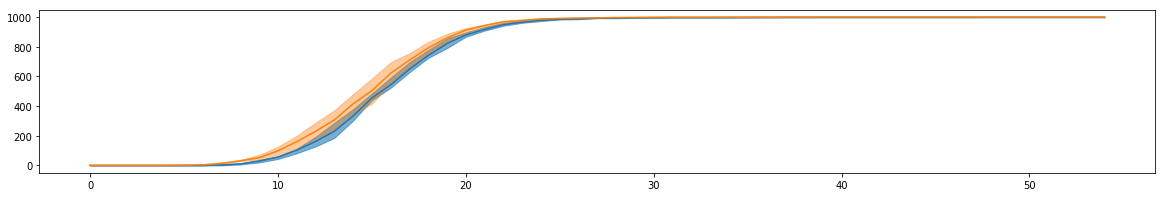

In [52]:
plt.figure(figsize=(20, 3))
data = count_cutoff_channel_res.copy()
color = "tab:blue"
xs = np.arange(data.shape[0])
y25 = np.percentile(data, 25, axis=-1)
y75 = np.percentile(data, 75, axis=-1)
plt.plot(data.mean(-1), color=color)
plt.fill_between(xs, y75, y25, color=color, alpha=alpha)
data = count_cutoff_channel_plain.copy()
color = "tab:orange"
alpha = 0.4
xs = np.arange(data.shape[0])
y25 = np.percentile(data, 25, axis=-1)
y75 = np.percentile(data, 75, axis=-1)
plt.plot(data.mean(-1), color=color)
plt.fill_between(xs, y75, y25, color=color, alpha=alpha)
plt.show()

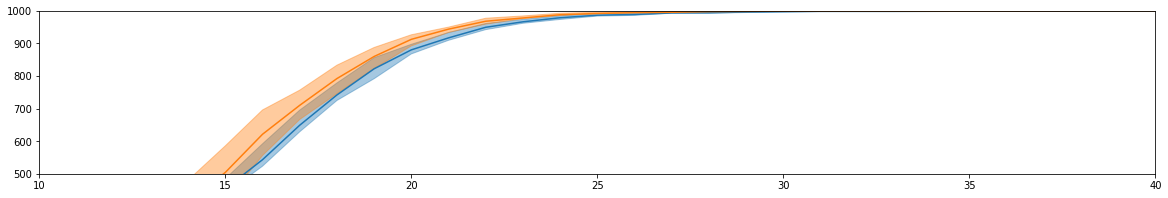

In [53]:
plt.figure(figsize=(20, 3))
data = count_cutoff_channel_res.copy()
color = "tab:blue"
xs = np.arange(data.shape[0])
y25 = np.percentile(data, 25, axis=-1)
y75 = np.percentile(data, 75, axis=-1)
plt.plot(data.mean(-1), color=color)
plt.fill_between(xs, y75, y25, color=color, alpha=alpha)
data = count_cutoff_channel_plain.copy()
color = "tab:orange"
alpha = 0.4
xs = np.arange(data.shape[0])
y25 = np.percentile(data, 25, axis=-1)
y75 = np.percentile(data, 75, axis=-1)
plt.plot(data.mean(-1), color=color)
plt.fill_between(xs, y75, y25, color=color, alpha=alpha)
plt.xlim(10, 40)
plt.ylim(500, 1000)
plt.show()

In [54]:
out_dir = "20201216"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [58]:
save_files = {
    "data": data_resnets,
    "model_names": resnet34_model_names,
    "model_keys": resnet34_model_keys,
    "weights": resnet34_weights,
}
out_path = os.path.join(out_dir, "data_resnets.pkl")
with open(out_path, "wb") as f:
    pickle.dump(save_files, f)

save_files = {
    "data": data_plainnets,
    "model_names": plainnet34_model_names,
    "model_keys": plainnet34_model_keys,
    "weights": plainnet34_weights,
}
out_path = os.path.join(out_dir, "data_plainnets.pkl")
with open(out_path, "wb") as f:
    pickle.dump(save_files, f)


In [154]:
i = 0

count_class = []
for class_index in range(n_classes):
    key = "{}-{}-{}".format(resnet34_model_names[i], key_layer, block_id)
    data = np.sum(data_resnets[key][0] == class_index, axis=-1)
    count_class.append(data)
count_class = np.asarray(count_class)

In [157]:
np.unravel_index(np.argmax(count_class), count_class.shape)

(565, 446)

In [161]:
np.unravel_index(np.argmin(count_class), count_class.shape)

(0, 1)

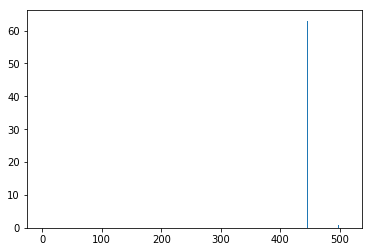

In [160]:
plt.bar(np.arange(count_class.shape[-1]), count_class[565])
plt.show()

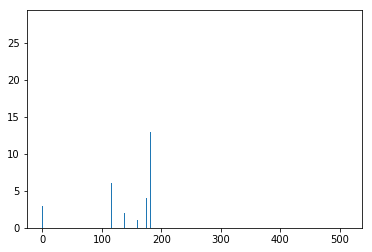

In [162]:
plt.bar(np.arange(count_class.shape[-1]), count_class[0])
plt.show()

In [163]:
from utils.imagenet1000_classname import imgnet_label_name

In [164]:
imgnet_label_name[0]

'tench, Tinca tinca'

In [170]:
i = 0

count_class = []
for class_index in range(n_classes):
    key = "{}-{}-{}".format(resnet34_model_names[i], key_layer, block_id)
    data = np.sum(data_resnets[key][0] == class_index, axis=-1)
    count_class.append(data)
count_class = np.asarray(count_class)

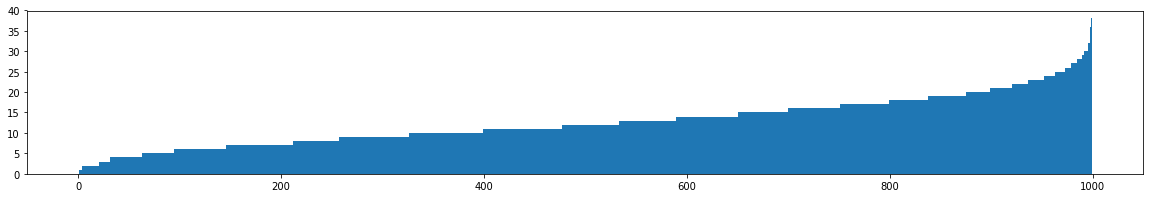

In [171]:
plt.figure(figsize=(20, 3))
plt.bar(np.arange(count_class.shape[0]), np.sort(np.count_nonzero(count_class, axis=-1)), width=1.0)
plt.show()

In [172]:
i = 0

count_class = []
for class_index in range(n_classes):
    key = "{}-{}-{}".format(plainnet34_model_names[i], key_layer, block_id)
    data = np.sum(data_plainnets[key][0] == class_index, axis=-1)
    count_class.append(data)
count_class = np.asarray(count_class)

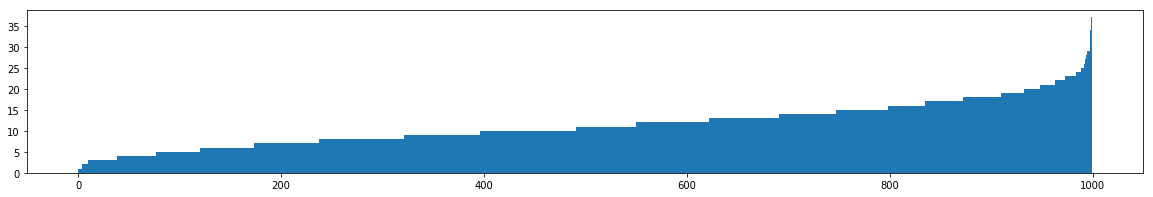

In [173]:
plt.figure(figsize=(20, 3))
plt.bar(np.arange(count_class.shape[0]), np.sort(np.count_nonzero(count_class, axis=-1)), width=1.0)
plt.show()

In [174]:

count_class_res = []
for i in range(len(resnet34_model_names)):
    count_class = []
    for class_index in range(n_classes):
        key = "{}-{}-{}".format(resnet34_model_names[i], key_layer, block_id)
        data = np.sum(data_resnets[key][0] == class_index, axis=-1)
        count_class.append(data)
    count_class = np.asarray(count_class)
    count_class_res.append(count_class.copy())
count_class_res = np.asarray(count_class_res)

In [178]:

count_class_plain = []
for i in range(len(plainnet34_model_names)):
    count_class = []
    for class_index in range(n_classes):
        key = "{}-{}-{}".format(plainnet34_model_names[i], key_layer, block_id)
        data = np.sum(data_plainnets[key][0] == class_index, axis=-1)
        count_class.append(data)
    count_class = np.asarray(count_class)
    count_class_plain.append(count_class.copy())
count_class_plain = np.asarray(count_class_plain)

In [175]:
count_class_res.shape

(4, 1000, 512)

In [177]:
np.count_nonzero(count_class_res, axis=-1)

(4, 1000)

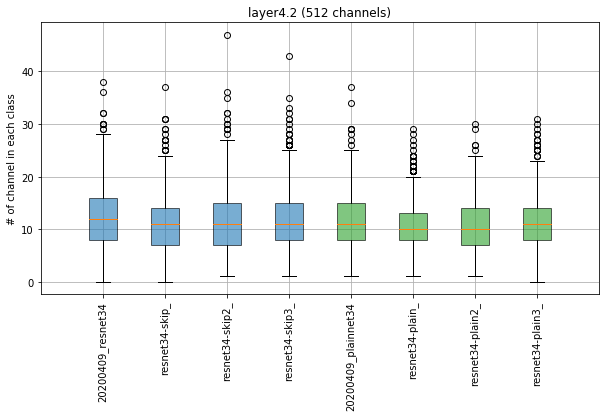

In [182]:
tmp_res = np.count_nonzero(count_class_res, axis=-1)
tmp_plain = np.count_nonzero(count_class_plain, axis=-1)
data_res_size = len(tmp_res)
data_plain_size = len(tmp_plain)
alpha = 0.6
channel_size = 512
plt.figure(figsize=(10, 5))
boxprops = {
    "facecolor": "tab:blue",
    "alpha": alpha,
}
plt.boxplot(tmp_res.T, positions=np.arange(data_res_size), patch_artist=True, boxprops=boxprops)
boxprops = {
    "facecolor": "tab:green",
    "alpha": alpha,
}
plt.boxplot(tmp_plain.T, positions=np.arange(data_res_size, data_plain_size + data_res_size), patch_artist=True, boxprops=boxprops)
plt.xlim(0 - 1, data_res_size + data_plain_size)
plt.xticks(ticks=np.arange(data_res_size + data_plain_size), labels=resnet34_model_names + plainnet34_model_names, rotation=90)
msg = "{}.{} ({} channels)".format(key_layer, block_id, channel_size)
plt.title(msg)
msg = "# of channel in each class"
plt.ylabel(msg)
# plt.ylim(vmin - 1, vmax + 1)
plt.grid()
plt.show()

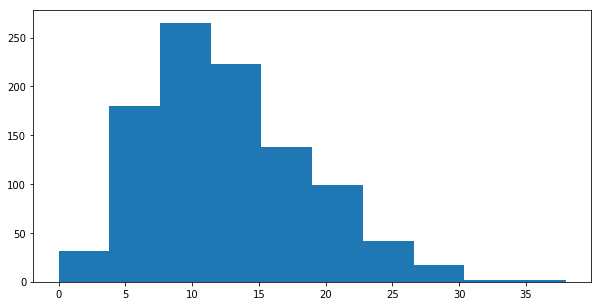

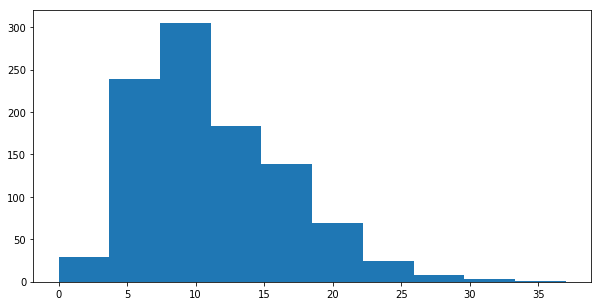

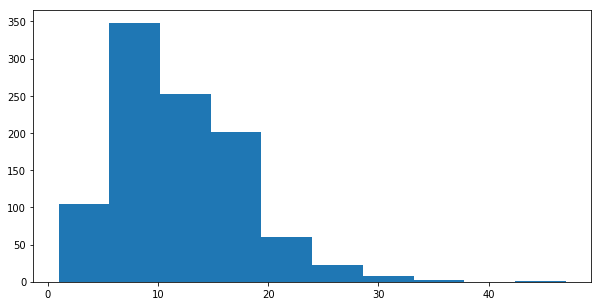

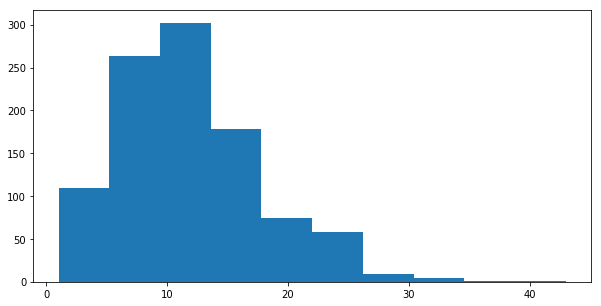

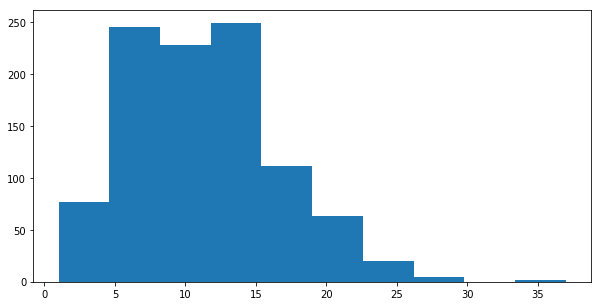

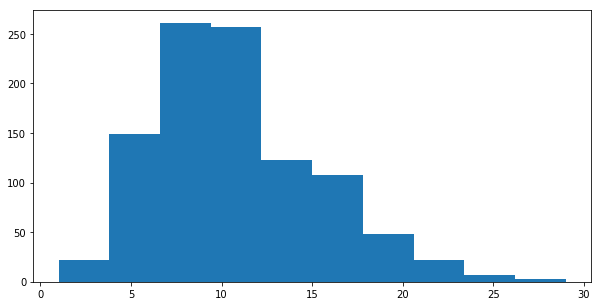

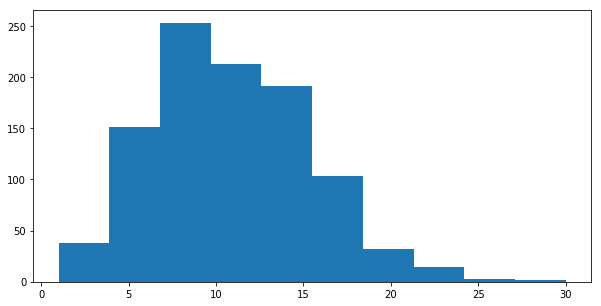

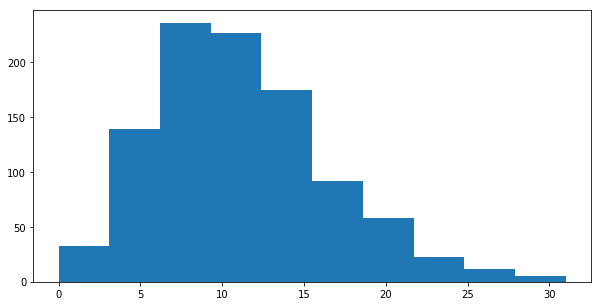

In [194]:
tmp_res = np.count_nonzero(count_class_res, axis=-1)
tmp_plain = np.count_nonzero(count_class_plain, axis=-1)
data_res_size = len(tmp_res)
data_plain_size = len(tmp_plain)
alpha = 0.6
channel_size = 512
for tmp in tmp_res:
    plt.figure(figsize=(10, 5))
    plt.hist(tmp)
    plt.show()
for tmp in tmp_plain:
    plt.figure(figsize=(10, 5))
    plt.hist(tmp)
    plt.show()


In [185]:
tmp_res.min(), tmp_plain.min()

(0, 0)

In [192]:
np.sort(tmp_res)[:, :10]

array([[0, 1, 1, 1, 2, 2, 2, 2, 2, 2],
       [0, 1, 1, 1, 1, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 2, 2, 2, 2, 2],
       [1, 1, 1, 2, 2, 2, 2, 2, 2, 2]])

In [193]:
np.sort(tmp_plain)[:, :10]

array([[1, 1, 1, 1, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 2, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 2, 2, 2, 2, 2, 2],
       [0, 1, 1, 1, 1, 2, 2, 2, 2, 2]])

In [57]:
import pandas as pd

In [65]:
np.repeat(np.arange(10), 2)

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9])

In [72]:
columns = [
    "class",
    "channel",
]
data = np.array([
    res_top_act_classes.reshape(-1),
    np.repeat(np.arange(512), 100)
])
df_res_top_act_classes = pd.DataFrame(data=data.T, columns=columns)

data = np.array([
    plain_top_act_classes.reshape(-1),
    np.repeat(np.arange(512), 100)
])
df_plain_top_act_classes = pd.DataFrame(data=data.T, columns=columns)

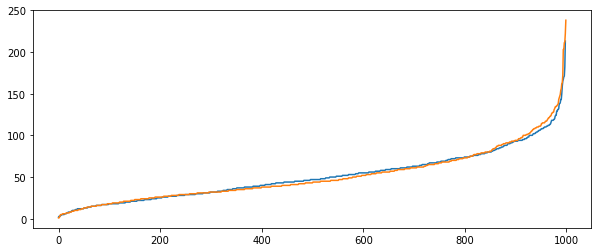

In [103]:
plt.figure(figsize=(10, 4))
data = np.array(df_res_top_act_classes.groupby("class").count())[:, 0]

plt.plot(np.sort(data))

data = np.array(df_plain_top_act_classes.groupby("class").count())[:, 0]

plt.plot(np.sort(data))

plt.show()

/home/genta/.pyenv/versions/dlb2-pytorch/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


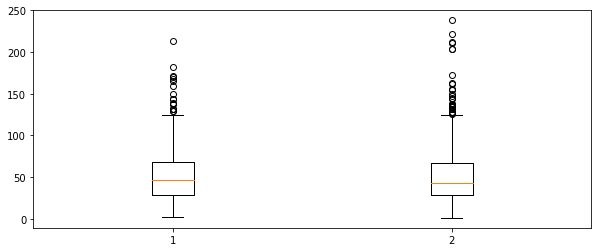

In [105]:
plt.figure(figsize=(10, 4))
res_data = np.array(df_res_top_act_classes.groupby("class").count())[:, 0]

plain_data = np.array(df_plain_top_act_classes.groupby("class").count())[:, 0]

plt.boxplot((res_data, plain_data))

plt.show()